# Render paper plots and tables

In [1]:
import math
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

**Note:** _Change_ the following path to the aggregated results file in your local system 
(can be obtained using the `parse-acs-results.ipynb` notebook).

In [2]:
ACS_AGG_RESULTS_PATH = Path("../results") / "aggregated-results.2024-08.csv"
ACS_AGG_RESULTS_PATH = Path(ACS_AGG_RESULTS_PATH)

In [3]:
results_df = pd.read_csv(ACS_AGG_RESULTS_PATH, index_col=0)
print(f"{results_df.shape=}")
results_df.head(2)

results_df.shape=(210, 64)


,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,name,is_inst,num_features,uses_all_features,fit_thresh_on_100,fit_thresh_accuracy,optimal_thresh,optimal_thresh_accuracy,score_stdev,score_mean
penai/gpt-4o-mini__ACSTravelTime__-1__Num,0.570906,0.315286,0.624340,0.553706,0.070915,0.876372,0.267584,0.149517,NaN,0.382569,...,GPT 4o mini (it),True,-1,True,0.250000,0.510013,0.450000,0.570968,0.223652,0.384149
penai/gpt-4o-mini__ACSTravelTime__-1__QA,0.551154,0.119294,0.812222,0.588927,0.113947,0.823835,0.404025,0.393327,0.393301,0.274655,...,GPT 4o mini (it),True,-1,True,0.998499,0.602202,0.970688,0.593339,0.365205,0.772858


Remove `gemma-2-*` results (need to investigate why results are so poor):

In [4]:
results_df = results_df.drop(index=[id_ for id_ in results_df.index if "gemma-2-" in id_.lower()])
print(f"{results_df.shape=}")

results_df.shape=(170, 64)


## Run baseline ML classifiers on the benchmark ACS tasks

In [5]:
DATA_DIR = Path("/fast/groups/sf") / "data"

In [6]:
ALL_TASKS = [
    "ACSIncome",
    "ACSMobility",
    "ACSEmployment",
    "ACSTravelTime",
    "ACSPublicCoverage",
]

model_col = "config_model_name"
task_col = "config_task_name"
numeric_prompt_col = "config_numeric_risk_prompting"

List all baseline classifiers here:

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier    # NOTE: requires `pip install xgboost`

baselines = {
    "LR": LogisticRegression(),
    "GBM": HistGradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
}

In [8]:
from folktexts.acs.acs_dataset import ACSDataset
from folktexts.evaluation import evaluate_predictions
from collections import defaultdict

def fit_and_eval(
    clf,
    X_train, y_train,
    X_test, y_test, s_test,
    fillna=False,
    save_scores_df_path: str = None,
) -> dict:
    """Fit and evaluate a given classifier on the given data."""
    assert len(X_train) == len(y_train) and len(X_test) == len(y_test) == len(s_test)

    train_nan_count = X_train.isna().any(axis=1).sum()
    if fillna and train_nan_count > 0:
        # Fill NaNs with value=-1
        X_train = X_train.fillna(axis="columns", value=-1)
        X_test = X_test.fillna(axis="columns", value=-1)

    # Fit on train data
    clf.fit(X_train, y_train)

    # Evaluate on test data
    y_test_scores = clf.predict_proba(X_test)[:, -1]
    test_results = evaluate_predictions(
        y_true=y_test.to_numpy(),
        y_pred_scores=y_test_scores,
        sensitive_attribute=s_test,
        threshold=0.5,
    )

    # Optionally, save test scores DF
    if save_scores_df_path:
        scores_df = pd.DataFrame({
            "risk_score": y_test_scores,
            "label": y_test,
        })
        scores_df.to_csv(save_scores_df_path)
        test_results["predictions_path"] = save_scores_df_path

    return test_results

def run_baselines(baselines, tasks) -> dict:
    """Run baseline classifiers on all acs tasks."""
    baseline_results = defaultdict(dict)

    # Prepare progress bar
    progress_bar = tqdm(
        total=len(tasks) * len(baselines),
        leave=True,
    )

    for task in tasks:
        progress_bar.set_postfix({"task": task})

        # Load ACS task data
        acs_dataset = ACSDataset.make_from_task(task=task, cache_dir=DATA_DIR)
    
        # Get train/test data
        X_train, y_train = acs_dataset.get_train()
        X_test, y_test = acs_dataset.get_test()
    
        # Get sensitive attribute test data
        s_test = None
        if acs_dataset.task.sensitive_attribute is not None:
            s_test = acs_dataset.get_sensitive_attribute_data().loc[y_test.index]
    
        for clf_name, clf in baselines.items():
            progress_bar.set_postfix({"task": task, "clf": clf_name})

            try:
                baseline_results[task][clf_name] = fit_and_eval(
                    clf=clf,
                    X_train=X_train, y_train=y_train,
                    X_test=X_test, y_test=y_test, s_test=s_test,
                    fillna=(clf_name == "LR"),
                    save_scores_df_path=ACS_AGG_RESULTS_PATH.parent / f"baseline_scores.{clf_name}.{task}.csv"
                )
            except Exception as err:
                logging.error(err)
            finally:
                progress_bar.update()

    return baseline_results

Flatten results and add extra columns.

In [9]:
def parse_baseline_results(baseline_results) -> list:
    """Flatten and parse baseline results."""
    parsed_results_list = list()
    
    for task, task_results in baseline_results.items():
    
        for clf, clf_results in task_results.items():
            parsed_results = clf_results.copy()
    
            parsed_results["config_task_name"] = task
            parsed_results["config_model_name"] = clf
            parsed_results["name"] = clf
            parsed_results["num_features"] = -1
            parsed_results["uses_all_features"] = True
    
            parsed_results_list.append(parsed_results)

    return parsed_results_list

Check if baseline results were already computed. If so, load csv; otherwise, compute and save.

In [10]:
BASELINE_RESULTS_PATH = ACS_AGG_RESULTS_PATH.parent / ("baseline-results." + ".".join(sorted(baselines.keys())) + ".csv")

# If saved results exists: load
if BASELINE_RESULTS_PATH.exists():
    print(f"Loading pre-computed baseline results from {BASELINE_RESULTS_PATH.as_posix()}")
    baselines_df = pd.read_csv(BASELINE_RESULTS_PATH, index_col=0)

# Compute baseline results
else:
    print(f"Computing baseline results and saving to {BASELINE_RESULTS_PATH.as_posix()}")
    # Compute baseline results
    baseline_results = run_baselines(baselines, tasks=ALL_TASKS)

    # Parse results
    parsed_results_list = parse_baseline_results(baseline_results)

    # Construct DF
    baselines_df = pd.DataFrame(parsed_results_list, index=[r["name"] for r in parsed_results_list])
    
    # Save DF to disk
    baselines_df.to_csv(BASELINE_RESULTS_PATH)

# Untie indices
baselines_df["new_index"] = [(r["name"] + "_" + r[task_col]) for _, r in baselines_df.iterrows()]
baselines_df = baselines_df.set_index("new_index", drop=True)

# Show 2 random rows
baselines_df.sample(2)

Loading pre-computed baseline results from ../results/baseline-results.GBM.LR.XGBoost.csv


,threshold,n_samples,n_positives,n_negatives,model_name,accuracy,tpr,fnr,fpr,tnr,...,equalized_odds_diff,roc_auc,ece,ece_quantile,predictions_path,config_task_name,config_model_name,name,num_features,uses_all_features
new_index,,,,,,,,,,,,,,,,,,,,,
XGBoost_ACSPublicCoverage,0.5,113829,33971,79858,NaN,0.801650,0.515175,0.484825,0.076486,0.923514,...,0.368044,0.839742,0.004371,0.004271,/fast/groups/sf/folktexts-results/2024-07-03/b...,ACSPublicCoverage,XGBoost,XGBoost,-1,True
GBM_ACSIncome,0.5,166450,61233,105217,NaN,0.813584,0.727973,0.272027,0.136594,0.863406,...,0.630389,0.890792,0.007721,0.007146,/fast/groups/sf/folktexts-results/2024-07-03/b...,ACSIncome,GBM,GBM,-1,True


In [11]:
all_results_df = pd.concat((results_df, baselines_df))
print(f"{all_results_df.shape=}")

all_results_df.shape=(185, 64)


## Prepare results table for each task

In [12]:
table_metrics = ["ece", "brier_score_loss", "roc_auc", "accuracy", "fit_thresh_accuracy", "score_stdev"] #, "score_mean"]

Add model size and model family columns:

In [13]:
from folktexts.llm_utils import get_model_size_B

all_results_df["model_size"] = [
    (
        get_model_size_B(row["name"], default=300)  # Set GPT 4o size as the largest (300B)
        if row["name"] not in baselines else "-"
    )
    for _, row in all_results_df.iterrows()
]

def get_model_family(model_name) -> str:
    if "gpt" in model_name.lower():
        return "OpenAI"
    elif "llama" in model_name.lower():
        return "Llama"
    elif "mistral" in model_name.lower() or "mixtral" in model_name.lower():
        return "Mistral"
    elif "gemma" in model_name.lower():
        return "Gemma"
    elif "yi" in model_name.lower():
        return "Yi"
    elif "qwen" in model_name.lower():
        return "Qwen"
    else:
        return "-"

all_results_df["model_family"] = [get_model_family(row[model_col]) for _, row in all_results_df.iterrows()]
all_results_df.groupby([task_col, "model_family"])["accuracy"].count()

config_task_name   model_family
ACSEmployment      -                3
                   Gemma            8
                   Llama            8
                   Mistral         12
                   OpenAI           2
                   Yi               4
ACSIncome          -                3
                   Gemma            8
                   Llama            8
                   Mistral         12
                   OpenAI           2
                   Yi               4
ACSMobility        -                3
                   Gemma            8
                   Llama            8
                   Mistral         12
                   OpenAI           2
                   Yi               4
ACSPublicCoverage  -                3
                   Gemma            8
                   Llama            8
                   Mistral         12
                   OpenAI           2
                   Yi               4
ACSTravelTime      -                3
                  

In [14]:
def model_sort_key(name, task_df):
    """Sort key for paper table rows."""

    if "gpt" in name.lower():
        key = 11
    elif "llama" in name.lower():
        key = 10
    elif "mixtral" in name.lower():
        key = 9
    elif "mistral" in name.lower():
        key = 8
    elif "yi" in name.lower():
        key = 7
    elif "gemma" in name.lower():
        key = 6
    else:
        return 0

    row = task_df.loc[name]
    # return (1e5 * key) + (row["model_size"] * 100) + int(row["is_inst"] * 10) + (1 if row[numeric_prompt_col] else 0)
    return (row["model_size"] * 1e9) + int(row["is_inst"] * 1e6) + 1e3 * (1 if row[numeric_prompt_col] else 0) + key


In [15]:
def latex_colored_float_format(val, all_values, higher_is_better=True):
    """Map a cell's value to its colored latex code.

    Current definition:
    - use cyan color gradient for good values;
    - use orange color gradient for bad values;
    - use no color for anything in between;
    """
    min_val, max_val = np.min(all_values), np.max(all_values)

    low_pct_val, high_pct_val = [
        min_val + (max_val - min_val) * interp_point
        for interp_point in [0.1, 0.9]
    ]

    # Use rounded value or original value for coloring?
    # > Using rounded value for consistency in table
    # val = np.round(val, decimals=2)

    # Use no color for middle 33% of values
    if low_pct_val <= val <= high_pct_val:
        return f"{val:.2f}"

    if val < low_pct_val:
        color = "orange" if higher_is_better else "cyan"
        color_value = 100 * (
            (low_pct_val - val) / (low_pct_val - min_val))
        
    elif val > high_pct_val:
        color = "cyan" if higher_is_better else "orange"
        color_value = 100 * (
            (val - high_pct_val) / (max_val - high_pct_val))

    else:
        raise RuntimeError(f"{val}")

    # Note: halving `color_value` to have softer colors
    color_value /= 4

    return (
        r"\cellcolor{"
        + f"{color}!{color_value:.1f}"
        + r"} "
        + f"{val:.2f}"
    )

higher_is_better_cols = {"roc_auc", "accuracy", "fit_thresh_accuracy"}

## Output latex results tables - colored!

Set whether to use **_Numeric_ prompting** or **_multiple-choice Q&A_ prompting**!

In [16]:
# NUMERIC_PROMPTING = False
NUMERIC_PROMPTING = True

Whether to **combine results from both prompting schemes** in the latex tables:

In [17]:
COMBINE_PROMPTING_RESULTS = True
# COMBINE_PROMPTING_RESULTS = False

In [18]:
from utils import prettify_model_name

for task in ALL_TASKS:
    task_df = all_results_df[all_results_df[task_col] == task]

    # Sort table rows
    sorted_df_index = sorted(
        task_df.index.tolist(),
        key=lambda id_: model_sort_key(id_, task_df),
        reverse=True,
    )

    latex_tab_cols = [numeric_prompt_col] + table_metrics

    # latex_table = task_df.sort_values(["model_family", "model_size", "is_inst"], ascending=False).set_index(model_col)[table_metrics].round(3)
    latex_table = task_df.loc[sorted_df_index].set_index(model_col)[latex_tab_cols].round(3)

    # Keep rows for a single selected prompting scheme
    latex_table = latex_table[
        (latex_table[numeric_prompt_col] == NUMERIC_PROMPTING)
        | latex_table[numeric_prompt_col].isna()
    ]

    # But optionally join with the columns of the other prompting scheme
    if COMBINE_PROMPTING_RESULTS:
        cols_to_keep = ["ece", "brier_score_loss", "roc_auc", "accuracy"]
        latex_table = latex_table[cols_to_keep]

        latex_table_other_prompt = task_df.loc[sorted_df_index].set_index(model_col)
        latex_table_other_prompt = latex_table_other_prompt[
            (latex_table_other_prompt[numeric_prompt_col] != NUMERIC_PROMPTING)
            | latex_table_other_prompt[numeric_prompt_col].isna()
        ][cols_to_keep].round(3)

        latex_table = latex_table.join(
            latex_table_other_prompt,
            how="left",
            lsuffix=" (num)" if NUMERIC_PROMPTING else " (mult. choice)",
            validate="1:1",
        )
    
    # Fill NaNs
    latex_table = latex_table.fillna("-")

    # Prettify model names
    latex_table["Model"] = [
        prettify_model_name(id_) if id_ not in baselines.keys() else id_
        for id_, row in latex_table.iterrows()
    ]
    latex_table.set_index("Model", drop=True, inplace=True)

    for col in set(latex_table.columns.tolist()) - {"score_stdev", numeric_prompt_col, "model_family"}:
        index_without_baselines = [name for name in latex_table.index if name not in baselines]
        index_baselines = list(baselines.keys())

        col_data = latex_table.loc[index_without_baselines, col].copy()

        new_col_data = [
            latex_colored_float_format(
                val=col_data.loc[id_], all_values=col_data,
                higher_is_better=any(col_name in col for col_name in higher_is_better_cols),
            )
            for id_ in index_without_baselines
        ] + [
            latex_table.loc[id_, col]
            for id_ in index_baselines
        ]

        # Set compatible dtype
        latex_table = latex_table.astype({col: str})

        # Set new data
        latex_table.loc[index_without_baselines + index_baselines, col] = new_col_data

    # Drop prompting column of not combining both
    latex_table = latex_table.drop(columns=numeric_prompt_col, errors="ignore")

    # Rename columns to be latex compatible
    latex_table = latex_table.rename(columns={col: col.replace("_", " ") for col in latex_table.columns})

    print(f"*** {task.upper()} ***\n")

    latex_table_str = latex_table.to_latex(float_format="%.2f")
    print(latex_table_str)

    tables_dir = ACS_AGG_RESULTS_PATH.parent / "tables"
    tables_dir.mkdir(exist_ok=True)
    with open(tables_dir / f"{task}-table.{COMBINE_PROMPTING_RESULTS=}.{NUMERIC_PROMPTING=}.tex", "w") as f_out:
        print(latex_table_str, file=f_out)
    
    print("")

*** ACSINCOME ***

\begin{tabular}{lllllllll}
\toprule
 & ece (num) & brier score loss (num) & roc auc (num) & accuracy (num) & ece & brier score loss & roc auc & accuracy \\
Model &  &  &  &  &  &  &  &  \\
\midrule
GPT 4o mini (it) & \cellcolor{cyan!25.0} 0.05 & \cellcolor{cyan!25.0} 0.16 & \cellcolor{cyan!20.6} 0.83 & \cellcolor{cyan!24.4} 0.78 & 0.24 & 0.24 & \cellcolor{cyan!17.6} 0.85 & 0.74 \\
Mixtral 8x22B (it) & 0.11 & \cellcolor{cyan!15.5} 0.17 & \cellcolor{cyan!25.0} 0.84 & \cellcolor{cyan!18.9} 0.77 & 0.21 & \cellcolor{cyan!3.6} 0.22 & \cellcolor{cyan!11.2} 0.85 & \cellcolor{cyan!11.1} 0.76 \\
Mixtral 8x22B & 0.13 & \cellcolor{cyan!3.6} 0.18 & \cellcolor{cyan!9.6} 0.82 & \cellcolor{cyan!2.4} 0.74 & \cellcolor{cyan!13.2} 0.17 & \cellcolor{cyan!21.6} 0.19 & \cellcolor{cyan!16.5} 0.85 & 0.68 \\
Llama 3 70B (it) & 0.25 & 0.23 & \cellcolor{cyan!22.1} 0.84 & 0.67 & 0.27 & 0.27 & \cellcolor{cyan!25.0} 0.86 & 0.69 \\
Llama 3 70B & 0.27 & 0.24 & \cellcolor{cyan!6.7} 0.82 & 0.54 & 0.2

## Render paper plots

Filter by the currently selected prompting scheme:

In [19]:
all_results_df_original = all_results_df.copy()

all_results_df = all_results_df[
    (all_results_df[numeric_prompt_col] == NUMERIC_PROMPTING)
    | (all_results_df[numeric_prompt_col].isna())
]

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", rc={"grid.linestyle": "--"})
plt.rc("figure", figsize=(4.5, 3.5), dpi=200)

palette_name = "tab10"   # "colorblind"
palette = sns.color_palette(palette_name)
sns.set_palette(palette_name)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [21]:
IMGS_DIR = ACS_AGG_RESULTS_PATH.parent / "imgs"
IMGS_DIR.mkdir(exist_ok=True)

def save_fig(fig, name, add_prompt_suffix=True):
    num_or_multiple_choice = "numeric-prompt" if NUMERIC_PROMPTING else "multiple-choice-prompt"
    save_path = (IMGS_DIR / name).with_suffix(".pdf")
    if add_prompt_suffix:
        save_path = save_path.with_suffix(f".{num_or_multiple_choice}.pdf")

    fig.savefig(save_path, bbox_inches="tight")
    print(f"Saved figure to '{save_path.as_posix()}'")

Load scores distributions for each model (and with varying degrees of information).

In [22]:
predictions_path_col = "predictions_path"

def load_model_scores_df(df_row: pd.Series) -> pd.DataFrame:
    """Loads csv containing model scores corresponding to the given DF row."""
    if predictions_path_col in df_row and not pd.isna(df_row[predictions_path_col]):
        return pd.read_csv(df_row[predictions_path_col], index_col=0)
    return None

In [23]:
scores_df_map = {
    id_: load_model_scores_df(row)
    for id_, row in tqdm(all_results_df.iterrows(), total=len(all_results_df))
}

  0%|          | 0/100 [00:00<?, ?it/s]

#### 1st page illustrative plot

In [24]:
example_task = "ACSIncome"

# example_model = "Mistral-7B-v0.1"
example_model = "Meta-Llama-3-70B"

baseline_model = "XGBoost"

In [25]:
# Data for baseline model
baseline_row = all_results_df[(all_results_df["name"] == baseline_model) & (all_results_df[task_col] == example_task)].iloc[0]

# Data for base and instruct models
example_df = all_results_df[
    (all_results_df[task_col] == example_task)
    & (all_results_df["base_name"] == example_model)
    & (all_results_df[numeric_prompt_col] == NUMERIC_PROMPTING)
]

# Sort examples_df to have (base, instruct) ordering
example_df = example_df.sort_values("is_inst", ascending=True)
example_df

,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,num_features,uses_all_features,fit_thresh_on_100,fit_thresh_accuracy,optimal_thresh,optimal_thresh_accuracy,score_stdev,score_mean,model_size,model_family
Meta-Llama-3-70B__ACSIncome__-1__Num,0.543953,0.134809,0.771466,0.636284,0.078752,0.887756,0.237630,0.270157,NaN,0.191080,...,-1,True,0.89560,0.784722,0.8956,0.784722,0.253299,0.638033,70,Llama
Meta-Llama-3-70B-Instruct__ACSIncome__-1__Num,0.665731,0.086680,0.880953,0.722658,0.061832,0.919317,0.230512,0.246092,NaN,0.232483,...,-1,True,0.75718,0.735764,0.8239,0.784848,0.290286,0.613968,70,Llama


/tmp/ipykernel_3388197/4070898515.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(["Base", "Instr."])
/tmp/ipykernel_3388197/4070898515.py:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(["Base", "Instr."])


Saved figure to '../results/imgs/teaser-Meta-Llama-3-70B.numeric-prompt.pdf'


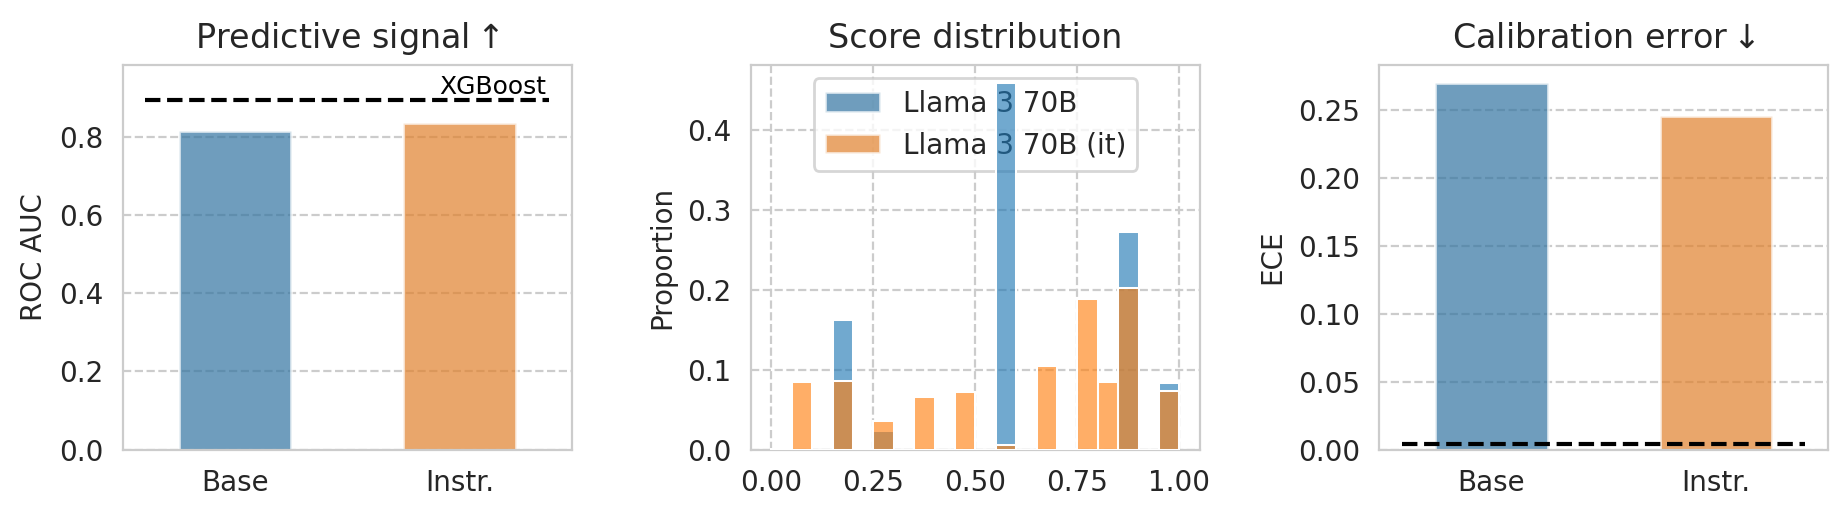

In [26]:
ALPHA = 0.7
N_BINS = 20

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(11, 2.5), gridspec_kw=dict(wspace=0.4))

###
# ROC barplot
###
sns.barplot(
    data=example_df,
    x="is_inst",
    y="roc_auc",
    hue="name",
    alpha=ALPHA,
    width=0.5,
    ax=ax1,
)

# Add horizontal line and label
ax1.axhline(y=baseline_row["roc_auc"], label=baseline_model, ls="--", color="black", xmin=0.05, xmax=0.95)
ax1.text(
    x=1.15,
    y=baseline_row["roc_auc"] + 1e-3,
    s=baseline_model,
    color="black",
    fontsize=9,
    ha='center',
    va='bottom',
    backgroundcolor='white',
    zorder=-1,
)

ax1.set_ylim(0, baseline_row["roc_auc"] + 9e-2)
# ax1.set_ylim(0.5, baseline_row["roc_auc"] + 7e-2)
ax1.set_ylabel("ROC AUC")
ax1.set_xlabel(None)
ax1.legend().remove()   # Remove the legend
ax1.set_xticklabels(["Base", "Instr."])
ax1.set_title("Predictive signal" + r"$\uparrow$")

###
# Score distribution
###
bins = np.histogram_bin_edges([], bins=N_BINS, range=(0, 1))
for id_ in example_df.index.tolist():
    sns.histplot(
        scores_df_map[id_]["risk_score"],
        alpha=ALPHA * 0.9,
        stat="proportion",
        bins=bins,
        zorder=100,
        ax=ax2,
    )

# # Draw baseline score distribution
# sns.histplot(
#     scores_df_map[baseline_row.name]["risk_score"],
#     alpha=1,
#     bins=bins,
#     stat="proportion",
#     fill=False,
#     color=palette[2],
#     edgecolor=palette[2],
#     hatch="/",
#     zorder=-1,
#     ax=ax2,
# )

ax2.set_xlabel(None)
ax2.set_title("Score distribution")

###
# Calibration error
###
sns.barplot(
    data=example_df,
    x="is_inst",
    y="ece",
    hue="name",
    alpha=ALPHA,
    width=0.5,
    ax=ax3,
)

# Add horizontal line and label
ax3.axhline(y=baseline_row["ece"], label=baseline_model, ls="--", color="black", xmin=0.05, xmax=0.95)

ax3.set_ylabel("ECE")
ax3.set_xlabel(None)
ax3.set_xticklabels(["Base", "Instr."])
ax3.set_title("Calibration error" + "$\downarrow$")
# ax3.legend(
#     loc="center left",
#     bbox_to_anchor=(1.05, 0.5),
# )

hs, ls = ax3.get_legend_handles_labels()
ax3.legend().remove()
ax2.legend(handles=hs[:2], labels=ls[:2], loc="upper center")

save_fig(fig, f"teaser-{example_model}")

#### Score distributions for base/instruct pairs

In [27]:
print(f"Plotting score distributions for the following task: {example_task}.")

task_df = all_results_df[
    (all_results_df[task_col] == example_task)
    & (
        (all_results_df[numeric_prompt_col] == NUMERIC_PROMPTING)
        | (all_results_df[numeric_prompt_col].isna())                  # Baseline models will have NaNs in this col.
    )]
print(f"{len(task_df)=}")

Plotting score distributions for the following task: ACSIncome.
len(task_df)=20


Sort model pairs as wished for the paper plot:

In [28]:
sorted_model_families = ["OpenAI", "Llama", "Mistral", "Yi", "Gemma", "-"]

model_pairs = sorted([
        (row["base_name"], row[model_col])
        for id_, row in task_df[task_df["is_inst"] == True].iterrows()
    ],
    key=lambda val: (
        1e6 * sorted_model_families.index((row := task_df[task_df[model_col] == val[0]].iloc[0])["model_family"])
        + row["model_size"]
    )
)
model_pairs

[('penai/gpt-4o-mini', 'penai/gpt-4o-mini'),
 ('Meta-Llama-3-8B', 'Meta-Llama-3-8B-Instruct'),
 ('Meta-Llama-3-70B', 'Meta-Llama-3-70B-Instruct'),
 ('Mistral-7B-v0.1', 'Mistral-7B-Instruct-v0.2'),
 ('Mixtral-8x7B-v0.1', 'Mixtral-8x7B-Instruct-v0.1'),
 ('Mixtral-8x22B-v0.1', 'Mixtral-8x22B-Instruct-v0.1'),
 ('Yi-34B', 'Yi-34B-Chat'),
 ('gemma-2b', 'gemma-1.1-2b-it'),
 ('gemma-7b', 'gemma-1.1-7b-it')]

Saved figure to '../results/imgs/score-distribution.numeric-prompt.pdf'


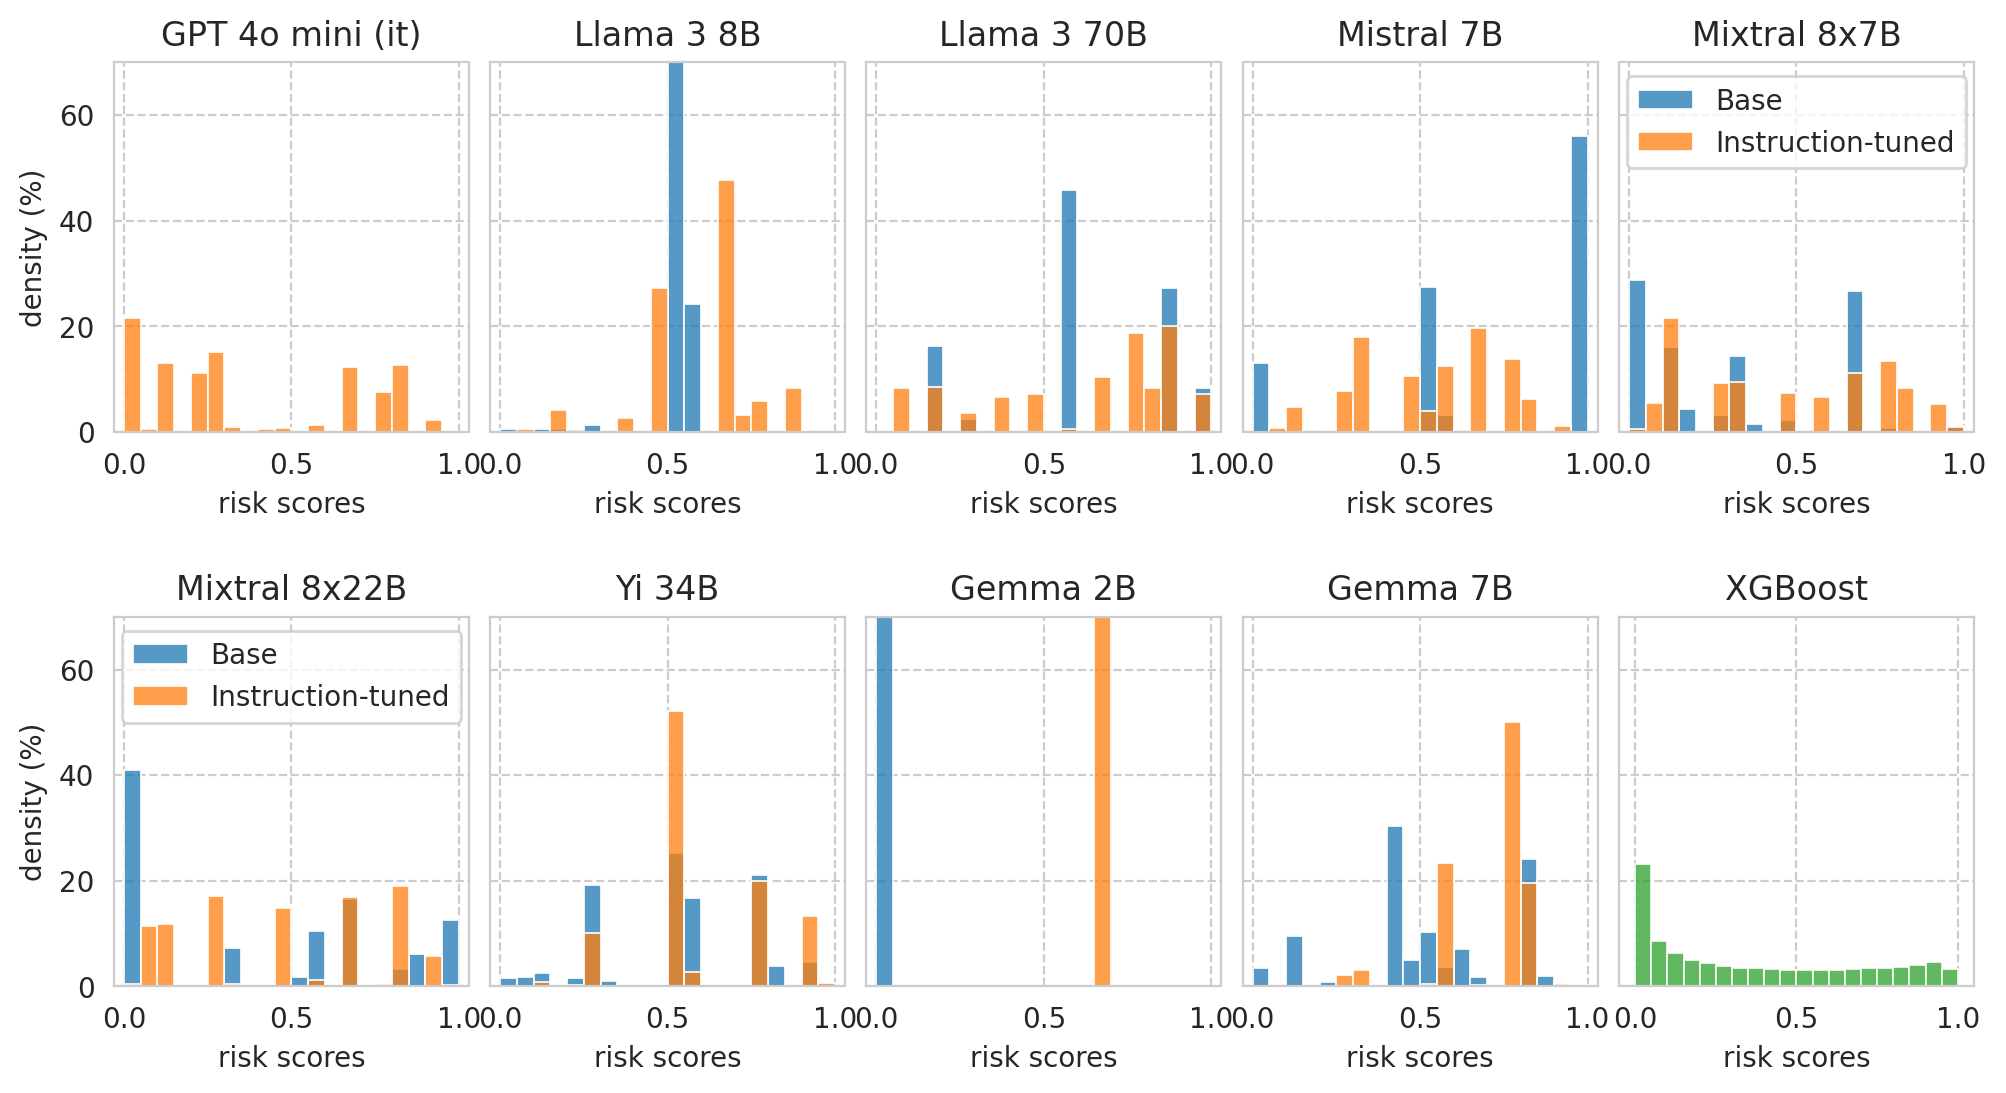

In [29]:
PLOT_THRESHOLD_LINE = False

N_PLOTS = len(model_pairs) + 1  # plus 1 for the XGBoost baseline

N_COLS = 5
N_ROWS = math.ceil(N_PLOTS / N_COLS)

fig, axes = plt.subplots(
    nrows=N_ROWS, ncols=N_COLS,
    figsize=(12, 3 * N_ROWS),
    sharey=True, sharex=False,
    gridspec_kw=dict(
        hspace=0.5,
        wspace=0.06,
    ),
)

# Plot settings
plot_config = dict(
    bins=N_BINS,
    binrange=(0, 1),
    stat="percent",
)

# Plot score distribution for model pairs
for idx, (base_name, instr_name) in enumerate(model_pairs):
    ax_row = idx // N_COLS
    ax_col = idx % N_COLS

    ax = axes[ax_row, ax_col]
    base_row = task_df[task_df[model_col] == base_name].iloc[0]
    it_row = task_df[task_df[model_col] == instr_name].iloc[0]

    # Get scores
    base_scores = scores_df_map[base_row.name]["risk_score"]
    it_scores = scores_df_map[it_row.name]["risk_score"]

    ax.set_title(base_row["name"])

    ax.set_xlabel("risk scores")
    if ax_col == 0:
        ax.set_ylabel("density (%)")

    if ax_row == 0:
        ax.set_ylim(0, 70)

    ax.set_xlim(-0.03, 1.03)

    # Render plot
    if "gpt" not in instr_name.lower():
        sns.histplot(base_scores, label="Base", color=palette[0], ax=ax, **plot_config)
    sns.histplot(it_scores, label="Instruction-tuned", color=palette[1], ax=ax, **plot_config)

    # Draw faint vertical line with t^* of each model
    threshold_col = "optimal_thresh"
    # threshold_col = "fit_thresh_on_100"

    if PLOT_THRESHOLD_LINE:
        ax.axvline(x=base_row[threshold_col], ls="--", color=palette[0], alpha=0.5)
        ax.axvline(x=it_row[threshold_col], ls="--", color=palette[1], alpha=0.5)

    # Render legend on a few sub-plots
    if (ax_col == 0 and ax_row == 1) or (ax_col == N_COLS-1 and ax_row == 0):
        ax.legend(loc="upper center")

        if PLOT_THRESHOLD_LINE:
            ax.text(
                x=base_row[threshold_col] - 5e-2,
                y=43,
                s="$t^*$",
                color=palette[0],
                fontsize=10,
                ha='center',
                va='bottom',
                # zorder=-1,
            ) #.set_bbox(dict(facecolor='white', alpha=0.5))
            
            ax.text(
                x=it_row[threshold_col] + 5e-2,
                y=43,
                s="$t^*$",
                color=palette[1],
                fontsize=10,
                ha='center',
                va='bottom',
                # zorder=-1,
            )
        

# Plot score distribution for XGBoost baseline
baseline_name = "XGBoost"
ax = axes[1, -1]
ax.set_title(baseline_name)

baseline_row = task_df[task_df["name"] == baseline_name].iloc[0]
xgboost_scores = scores_df_map[baseline_row.name]["risk_score"]

sns.histplot(
    xgboost_scores,
    label=baseline_name,
    color=palette[2],
    ax=ax,
    **plot_config,
)

ax.set_xlabel("risk scores")

# # Remove unused plot?
# axes[1, 3].remove()

axes[1, 4].set_ylabel("density (%)")
axes[1, 4].set_yticks([0, 20, 40, 60])
axes[1, 4].set_yticklabels([0, 20, 40, 60])

plt.plot()

# Save figure
save_fig(fig, f"score-distribution" + ("_with-threshold" if PLOT_THRESHOLD_LINE else ""))

## Calibration curves

Base models vs Instruction-tuned models:

In [30]:
TASK = "ACSIncome"

# df = results_df[(results_df[task_col] == TASK) & (results_df[numeric_prompt_col] == NUMERIC_PROMPTING)]

df = all_results_df[(all_results_df[task_col] == TASK) & (all_results_df[numeric_prompt_col] == NUMERIC_PROMPTING)]
print(f"{len(df)=}")

len(df)=17


Saved figure to '../results/imgs/calibration-curves-base-and-instr.numeric-prompt.pdf'


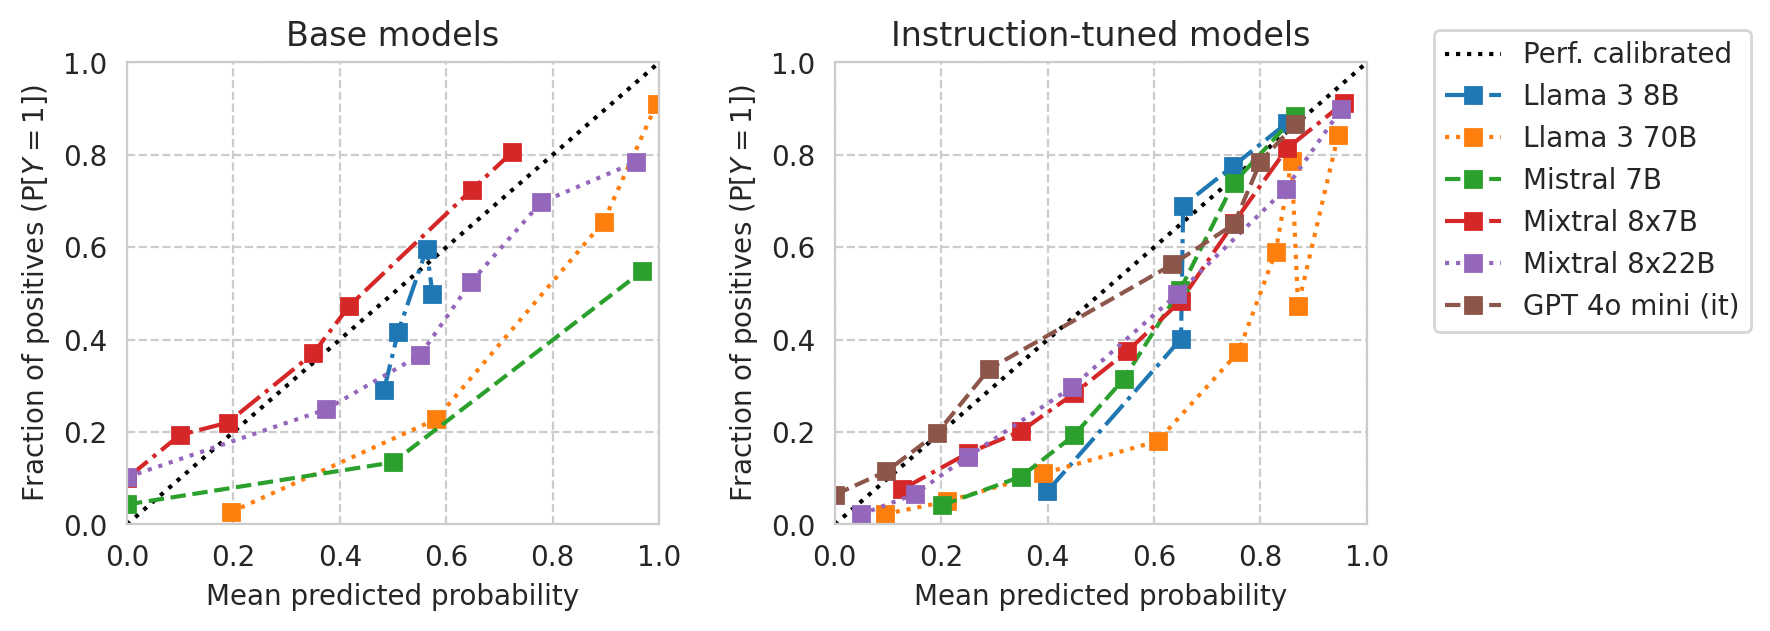

In [31]:
from sklearn.calibration import CalibrationDisplay
from utils import prettify_model_name

base_models_to_plot = [m for m in df["base_name"].unique() if "gemma" not in m.lower()]

base_models_to_plot = [
    "Meta-Llama-3-8B",
    "Meta-Llama-3-70B",
    "Mistral-7B-v0.1",
    "Mixtral-8x7B-v0.1",
    "Mixtral-8x22B-v0.1",
    # "Yi-34B",
]

instr_models_to_plot = [
    df[
        (df["base_name"] == m)
        & (df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

# Add GPT models if any
instr_models_to_plot += [m[model_col] for _, m in df.iterrows() if "gpt" in m["name"].lower()]

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), gridspec_kw=dict(wspace=0.33), sharey=False)

# Plot base models
for ax, model_list in zip(axes, (base_models_to_plot, instr_models_to_plot)):
    
    for idx, m in enumerate(model_list):

        curr_row = df[df[model_col] == m].iloc[0]
        curr_scores = scores_df_map[curr_row.name]

        disp = CalibrationDisplay.from_predictions(
            y_true=curr_scores["label"],
            y_prob=curr_scores["risk_score"],
            n_bins=10,
            strategy="quantile",
            name=prettify_model_name(curr_row["base_name"]),
            linestyle=["-.", ":", "--"][idx % 3],
            ax=ax,
        )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

ylabel = "Fraction of positives " + r"$\left(\mathrm{P}[Y=1]\right)$"
axes[0].set_ylabel(ylabel)
axes[1].set_ylabel(ylabel)

xlabel = "Mean predicted probability" # + r" $(\mathbb{E}[R])$"
axes[0].set_xlabel(xlabel)
axes[1].set_xlabel(xlabel)

axes[0].set_title("Base models")
axes[1].set_title("Instruction-tuned models")

axes[0].legend().remove()

# Legent to the right of the right-most plot
h, l = axes[1].get_legend_handles_labels()
l[0] = "Perf. calibrated"
axes[1].legend(handles=h, labels=l, loc="upper left", bbox_to_anchor=(1.1, 1.1))


plt.plot()

save_fig(fig, f"calibration-curves-base-and-instr.pdf")

### Same plot but only with large models (> 30B)

Saved figure to '../results/imgs/calibration-curves-base-and-instr.large-models.numeric-prompt.pdf'


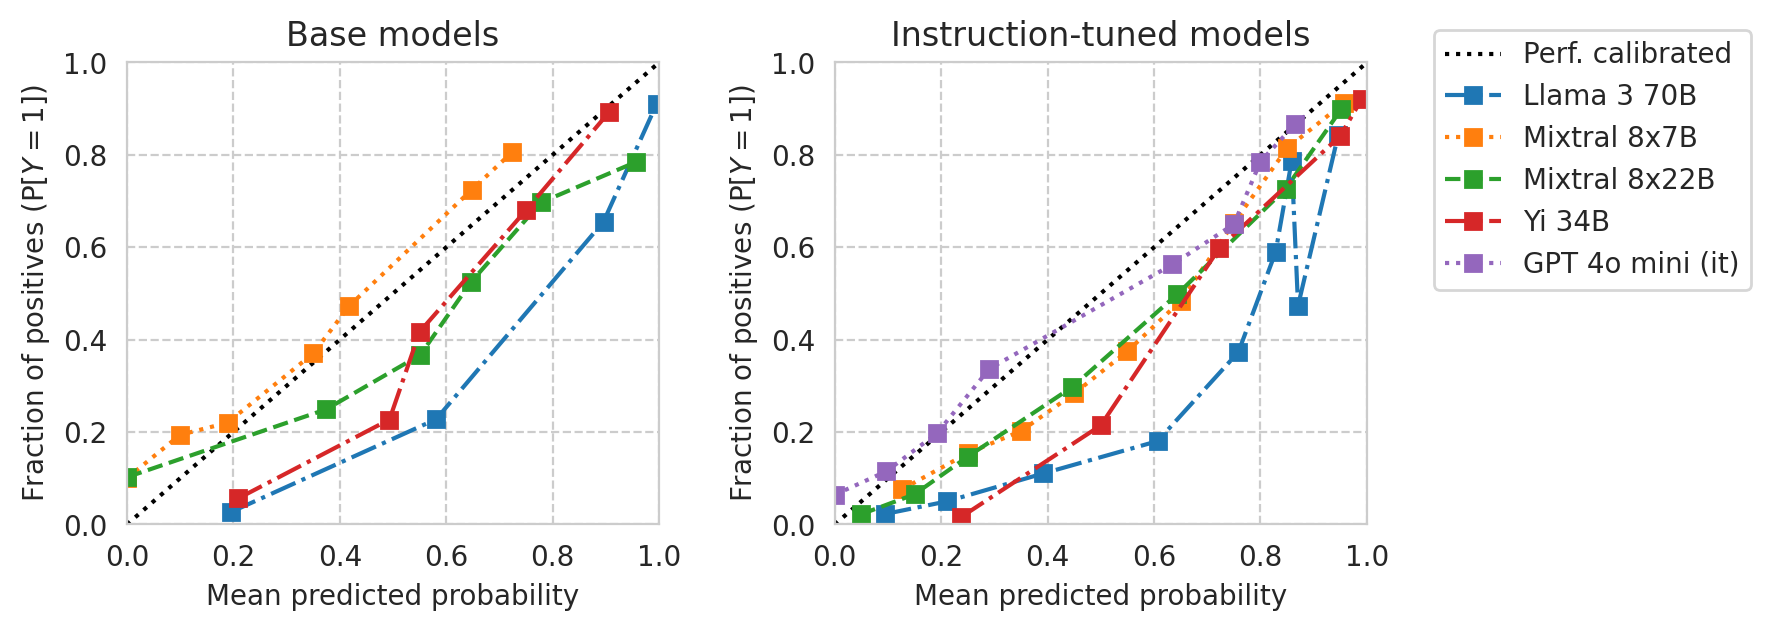

In [32]:
from sklearn.calibration import CalibrationDisplay
from utils import prettify_model_name

base_models_to_plot = [m for m in df["base_name"].unique() if "gemma" not in m.lower()]

base_models_to_plot = [
    "Meta-Llama-3-70B",
    "Mixtral-8x7B-v0.1",
    "Mixtral-8x22B-v0.1",
    "Yi-34B",
]

instr_models_to_plot = [
    df[
        (df["base_name"] == m)
        & (df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

# Add GPT models if any
instr_models_to_plot += [m[model_col] for _, m in df.iterrows() if "gpt" in m["name"].lower()]

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), gridspec_kw=dict(wspace=0.33), sharey=False)

# Plot base models
for ax, model_list in zip(axes, (base_models_to_plot, instr_models_to_plot)):
    
    for idx, m in enumerate(model_list):

        curr_row = df[df[model_col] == m].iloc[0]
        curr_scores = scores_df_map[curr_row.name]

        disp = CalibrationDisplay.from_predictions(
            y_true=curr_scores["label"],
            y_prob=curr_scores["risk_score"],
            n_bins=10,
            strategy="quantile",
            name=prettify_model_name(curr_row["base_name"]),
            linestyle=["-.", ":", "--"][idx % 3],
            ax=ax,
        )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

ylabel = "Fraction of positives " + r"$\left(\mathrm{P}[Y=1]\right)$"
axes[0].set_ylabel(ylabel)
axes[1].set_ylabel(ylabel)

xlabel = "Mean predicted probability" # + r" $(\mathbb{E}[R])$"
axes[0].set_xlabel(xlabel)
axes[1].set_xlabel(xlabel)

axes[0].set_title("Base models")
axes[1].set_title("Instruction-tuned models")

axes[0].legend().remove()

# Legent to the right of the right-most plot
h, l = axes[1].get_legend_handles_labels()
l[0] = "Perf. calibrated"
axes[1].legend(handles=h, labels=l, loc="upper left", bbox_to_anchor=(1.1, 1.1))

plt.plot()

save_fig(fig, f"calibration-curves-base-and-instr.large-models.pdf")

### Smaller to use for both prompting schemes side by side

Saved figure to '../results/imgs/calibration-curves-base-and-instr.large-models.smaller.numeric-prompt.pdf'


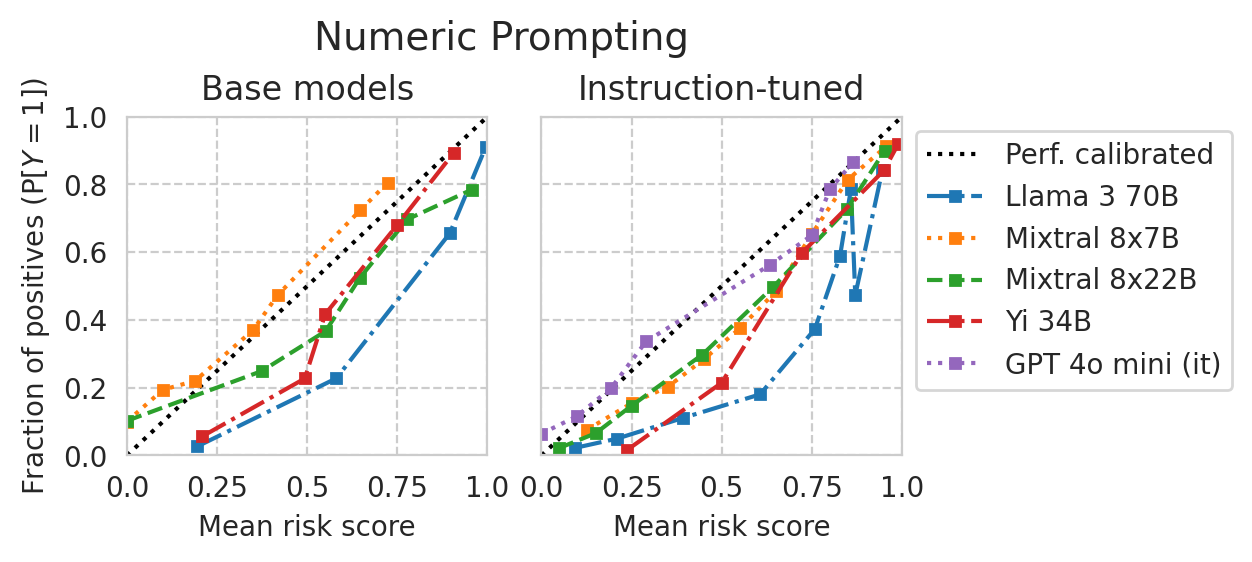

In [33]:
from sklearn.calibration import CalibrationDisplay
from utils import prettify_model_name

base_models_to_plot = [m for m in df["base_name"].unique() if "gemma" not in m.lower()]

base_models_to_plot = [
    "Meta-Llama-3-70B",
    "Mixtral-8x7B-v0.1",
    "Mixtral-8x22B-v0.1",
    "Yi-34B",
]

instr_models_to_plot = [
    df[
        (df["base_name"] == m)
        & (df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

# Add GPT models if any
instr_models_to_plot += [m[model_col] for _, m in df.iterrows() if "gpt" in m["name"].lower()]

fig, axes = plt.subplots(ncols=2, figsize=(5, 2.2), gridspec_kw=dict(wspace=0.15), sharey=True)

# Plot base models
for ax, model_list in zip(axes, (base_models_to_plot, instr_models_to_plot)):
    
    for idx, m in enumerate(model_list):

        curr_row = df[df[model_col] == m].iloc[0]
        curr_scores = scores_df_map[curr_row.name]

        disp = CalibrationDisplay.from_predictions(
            y_true=curr_scores["label"],
            y_prob=curr_scores["risk_score"],
            n_bins=10,
            strategy="quantile",
            name=prettify_model_name(curr_row["base_name"]),
            linestyle=["-.", ":", "--"][idx % 3],
            ax=ax,
            ms=3.5,
        )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

ylabel = "Fraction of positives " + r"$\left(\mathrm{P}[Y=1]\right)$"
axes[0].set_ylabel(ylabel)
# axes[1].set_ylabel(ylabel)
axes[1].set_ylabel("")

# xlabel = "Mean predicted probability" # + r" $(\mathbb{E}[R])$"
xlabel = "Mean risk score"
axes[0].set_xlabel(xlabel)
axes[1].set_xlabel(xlabel)

axes[0].set_title("Base models")
axes[1].set_title("Instruction-tuned")

# Set prettier x ticks
xticks = (0, 0.25, 0.5, 0.75, 1)
xticks_labels = ("0.0", "0.25", "0.5", "0.75", "1.0")
axes[0].set_xticks(xticks, labels=xticks_labels)
axes[1].set_xticks(xticks, labels=xticks_labels)

axes[0].legend().remove()

# Legent to the right of the right-most plot
if NUMERIC_PROMPTING:
    h, l = axes[1].get_legend_handles_labels()
    l[0] = "Perf. calibrated"
    axes[1].legend(handles=h, labels=l, loc="upper left", bbox_to_anchor=(1, 1))
else:
    axes[1].legend().remove()

# Figure title
if NUMERIC_PROMPTING:
    title = "Numeric Prompting"
else:
    title = "Multiple-choice Prompting"
plt.suptitle(title, y=1.1, fontsize=14)

plt.plot()

save_fig(fig, f"calibration-curves-base-and-instr.large-models.smaller.pdf")

## Calibration per sub-group
Plot calibration curves per race sub-group, for each model pair.

In [34]:
%%time
acs_dataset = ACSDataset.make_from_task(task=TASK, cache_dir=DATA_DIR)

Loading ACS data...
CPU times: user 41.3 s, sys: 28.3 s, total: 1min 9s
Wall time: 1min 9s


Plot:

In [35]:
# Omit small groups from the plots (results can be too noisy)
OMIT_GROUPS_BELOW_PCT = 4
N_BINS = 10

In [36]:
sens_attr_col = "RAC1P"
sens_attr_map = {
    1: "White",
    2: "Black",
    6: "Asian",
    # 8: "Other",   # some other race alone
}

name_to_sens_attr_map = {val: key for key, val in sens_attr_map.items()}

def plot_cali_curve(model_id, ax, df):
    """Plot sub-group calibration curves using sklearn"""

    curr_row = df.loc[model_id]
    curr_scores_df = scores_df_map[curr_row.name]

    y_true = curr_scores_df["label"].to_numpy()
    y_scores = curr_scores_df["risk_score"].to_numpy()

    sens_attr = acs_dataset.data.loc[curr_scores_df.index][sens_attr_col].to_numpy()

    for idx, group_val in enumerate(np.unique(sens_attr)):
        group_filter = sens_attr == group_val

        if np.sum(group_filter) < len(group_filter) * 0.01 * OMIT_GROUPS_BELOW_PCT:
            # print(f"Skipping group={group_val}")
            continue

        disp = CalibrationDisplay.from_predictions(
            y_true=y_true[group_filter],
            y_prob=y_scores[group_filter],
            n_bins=N_BINS,
            # strategy="uniform",
            strategy="quantile",
            name=str(sens_attr_map.get(group_val, group_val)),
            linestyle=["-.", ":", "--"][idx % 3],
            ax=ax,
        )

    # Set other plot settings
    ax.set_title(curr_row["name"])
    return disp

In [37]:
from folktexts.evaluation import bootstrap_estimate

def plot_cali_curve_ci(model_id, ax, df, ci=95):
    """Plot sub-group calibration curves with bootstrap confidence intervals"""

    curr_row = df.loc[model_id]
    curr_scores_df = scores_df_map[curr_row.name]

    y_true = curr_scores_df["label"].to_numpy()
    y_scores = curr_scores_df["risk_score"].to_numpy()

    sens_attr = acs_dataset.data.loc[curr_scores_df.index][sens_attr_col].to_numpy()

    # Compute bins
    if len(np.unique(y_scores)) == 1:
        ax.set_title(curr_row["name"])
        return

    y_scores_binned, bin_edges = pd.qcut(y_scores, q=N_BINS, retbins=True, duplicates="drop")
    bin_names = y_scores_binned.categories   # Name used for each bin: "(bin_low_range, bin_high_range)"

    # To hold plot render artifacts
    plot_artifacts = {}

    for idx, group_val in enumerate(np.unique(sens_attr)):
        group_filter = sens_attr == group_val

        if (
            np.sum(group_filter) < len(group_filter) * 0.01 * OMIT_GROUPS_BELOW_PCT
            or group_val not in sens_attr_map.keys()
        ):
            # print(f"Skipping group={group_val}")
            continue

        group_labels = y_true[group_filter]
        group_scores = y_scores[group_filter]

        group_cali_points = []
        for b in bin_names:
            bin_filter = y_scores_binned == b

            group_labels_current_bin = y_true[group_filter & bin_filter]
            group_scores_current_bin = y_scores[group_filter & bin_filter]

            results = bootstrap_estimate(
                eval_func=lambda labels, scores, sensattr: {
                    "mean_score": np.mean(scores),
                    "mean_label": np.mean(labels),
                },
                y_true=group_labels_current_bin,
                y_pred_scores=group_scores_current_bin,
                sensitive_attribute=None,
            )

            # Store plot point for this bin
            group_cali_points.append((
                results["mean_score_mean"],    # x coordinate
                results["mean_label_mean"],    # y coordinate
                (                              # y coordinate c.i. range
                    results["mean_label_low-percentile"],
                    results["mean_label_high-percentile"],
                ),
            ))

        # Get group label from sensitive attribute map
        group_label = str(sens_attr_map.get(group_val, group_val))
        
        # Plot this group's calibration curve w/ conf. intervals!
        line, caps, bars = ax.errorbar(
            # x=[mean_score for mean_score, *_ in group_cali_points],
            x=[(bin_edges[idx-1] + bin_edges[idx]) / 2. for idx in range(1, len(bin_edges))],
            y=[mean_label for _, mean_label, _ in group_cali_points],
            yerr=np.hstack(
                [
                    np.abs(np.array(yerr_range).reshape(2, 1) - y)
                    for _x, y, yerr_range in group_cali_points]
            ),
            fmt="o", markersize=1,
            linestyle=["-.", "-", "--"][idx % 3],
            linewidth=2,
            label=group_label,
        )
        plot_artifacts[group_label] = (line, caps, bars)
    
    # Global plot settings
    ax.plot(
        [0,1], [0,1],
        ls="dotted", color="black",
    )

    # Draw custom legend
    handles = []
    for group, (l, c, b) in plot_artifacts.items():
        l.set_label(group)
        l.set_markersize(0)
        handles.append(l)

    # Perfectly calibrated line
    perf_cal_line = plt.Line2D([], [], ls=":", color="black", label="Perf. calibrated")

    # Confidence interv. marker line
    conf_int_line = plt.Line2D([], [], lw=0, ms=10, marker="|", markeredgewidth=2, color="grey", label="$95\%$ conf. int.")
    
    ax.legend(handles=handles + [conf_int_line, perf_cal_line])
    ax.set_title(curr_row["name"])

    return disp

### Plot sub-group calibration (with confidence intervals)

  0%|          | 0/7 [00:00<?, ?it/s]

Saved figure to '../results/imgs/calibration-curves-per-subgroup.Meta-Llama-3-8B.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Meta-Llama-3-70B.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Mistral-7B-v0.1.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Mixtral-8x7B-v0.1.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Mixtral-8x22B-v0.1.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Yi-34B.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.None.numeric-prompt.pdf'


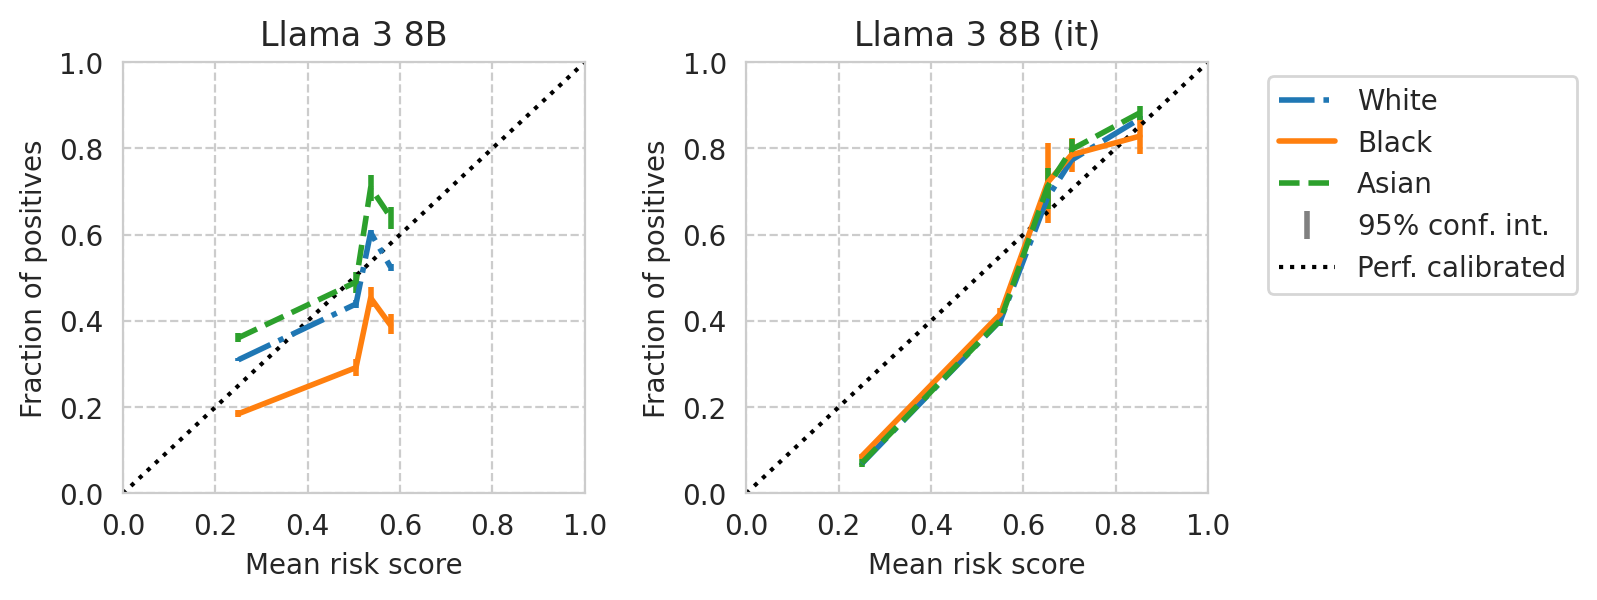

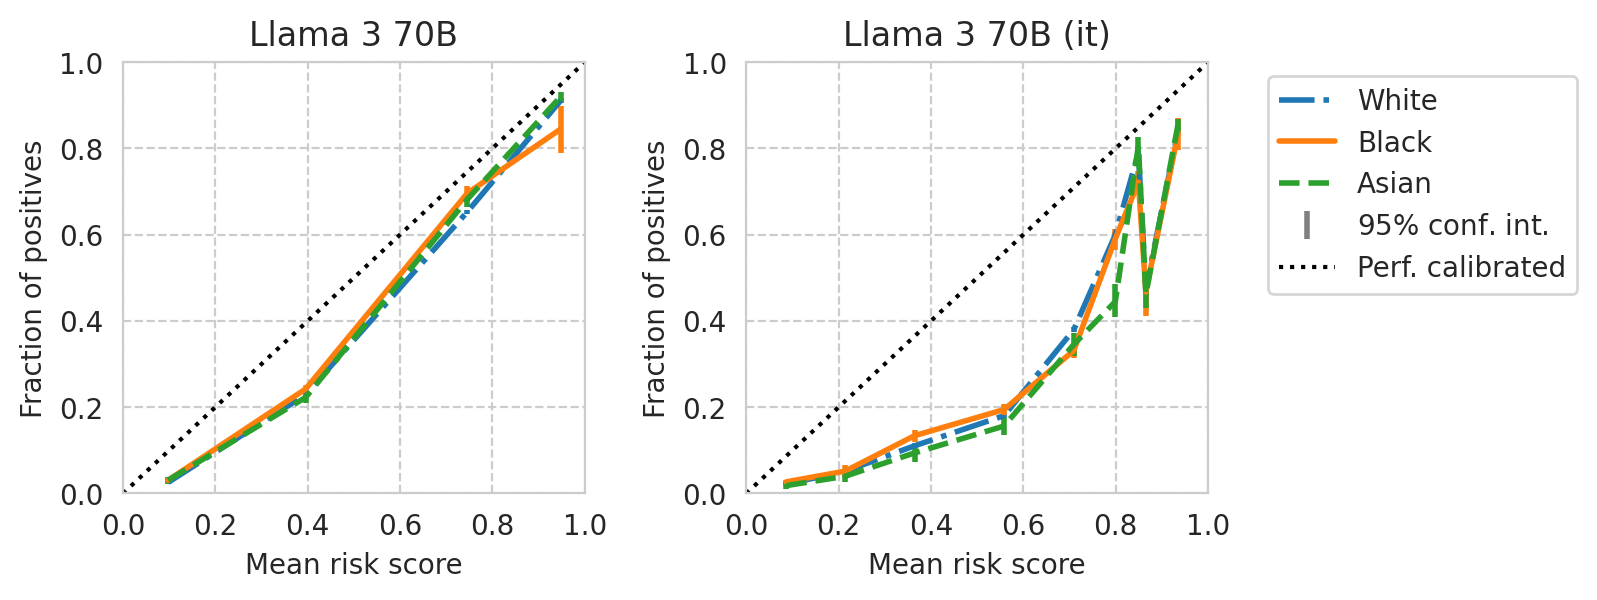

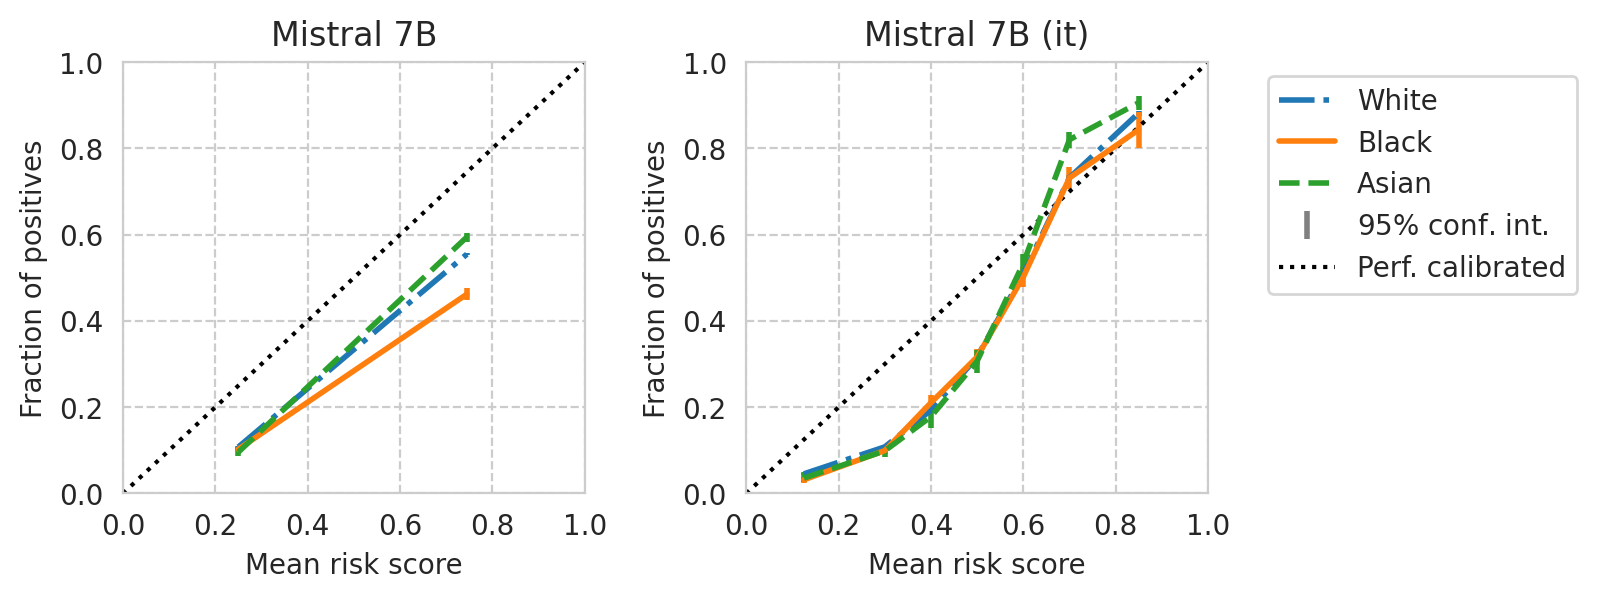

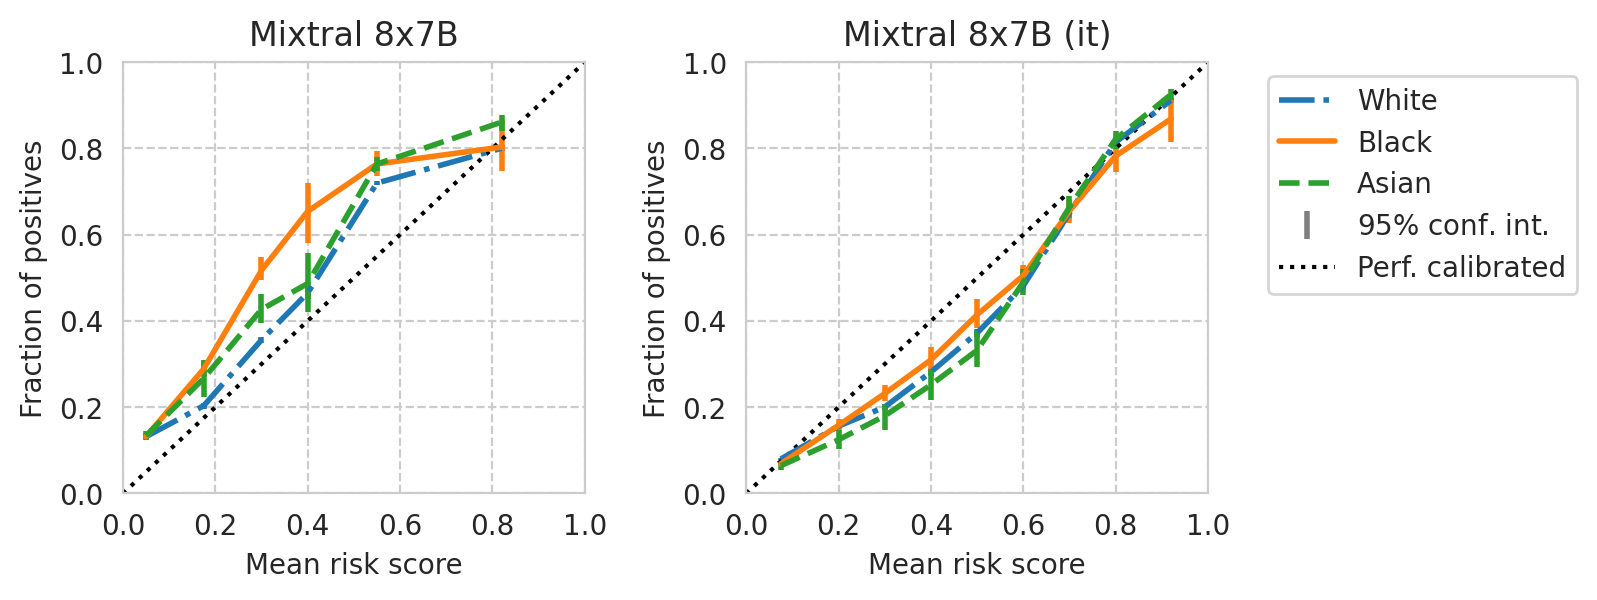

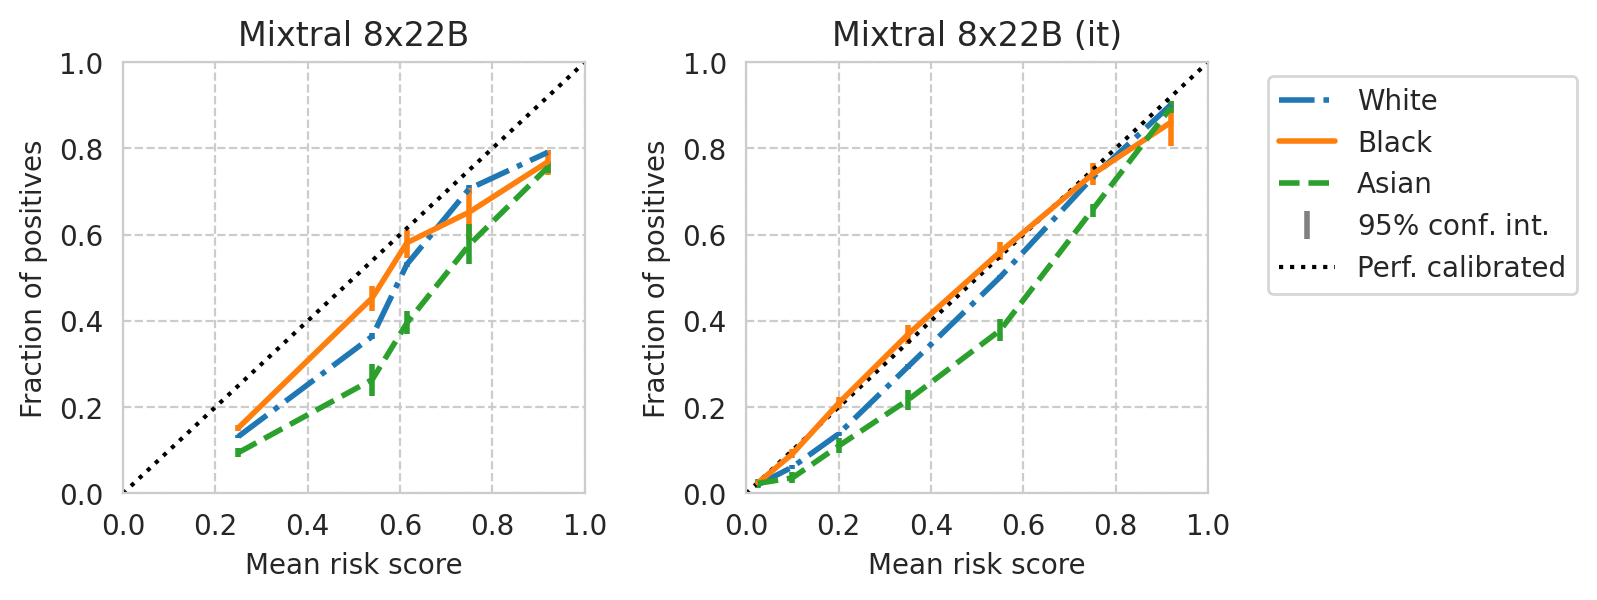

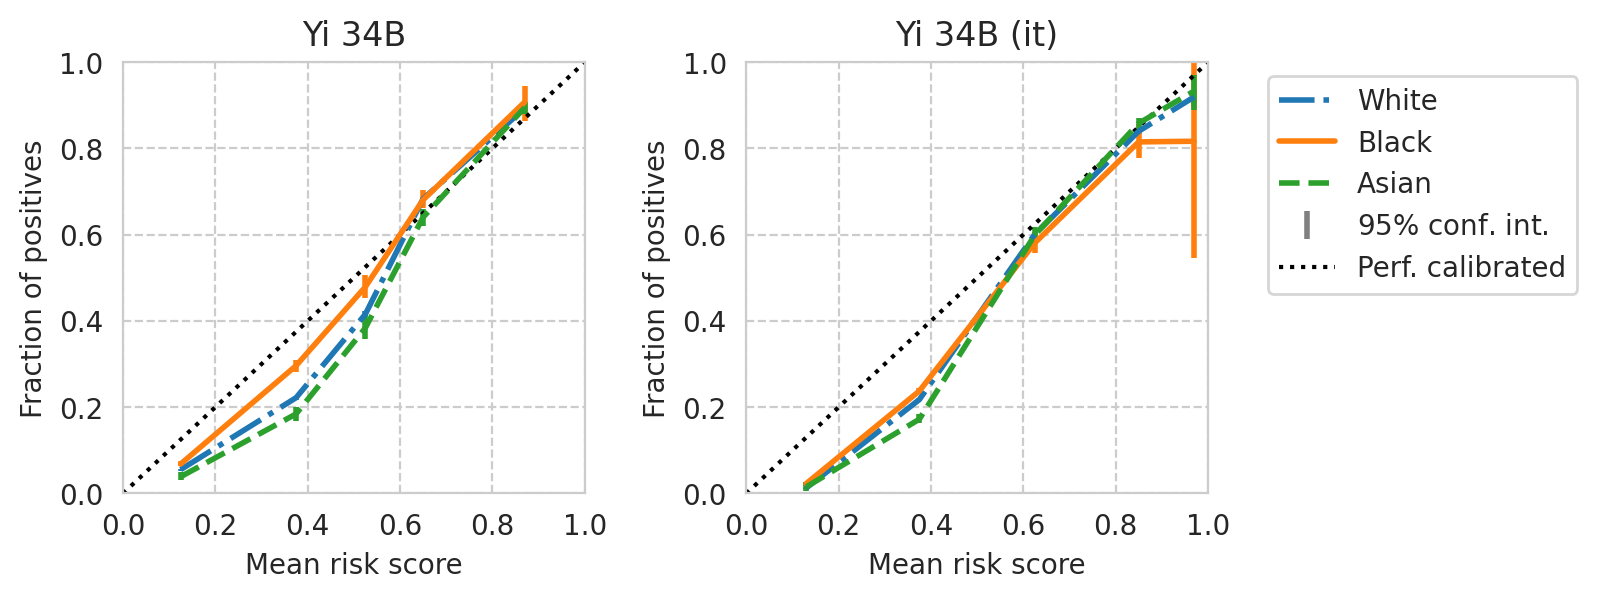

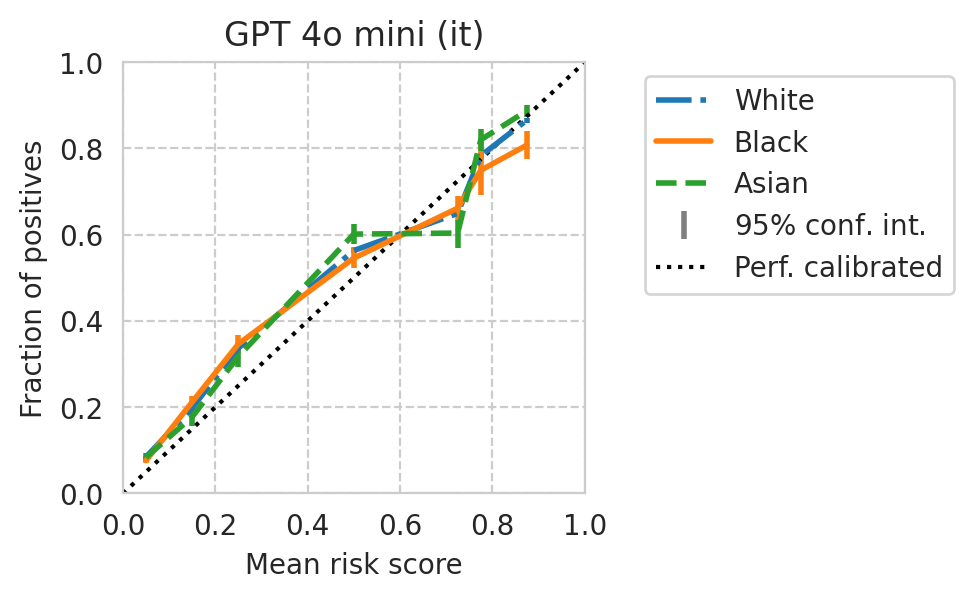

In [38]:
from sklearn.calibration import CalibrationDisplay

# Get results for the current task
task_df = all_results_df[all_results_df[task_col] == TASK]

# Get all base/instruct model pairs
base_models_to_plot = [
    "Meta-Llama-3-8B",
    "Meta-Llama-3-70B",
    "Mistral-7B-v0.1",
    "Mixtral-8x7B-v0.1",
    "Mixtral-8x22B-v0.1",
    "Yi-34B",
]
# NOTE: Gemma models have degenerate distributions that always predict the same score, can't plot calibration properly...

instr_models_to_plot = [
    df[
        (df["base_name"] == m)
        & (df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

# Add GPT models if any
instr_models_to_plot += [m[model_col] for _, m in df.iterrows() if "gpt" in m["name"].lower()]
base_models_to_plot += [None for _ in range(len(instr_models_to_plot) - len(base_models_to_plot))]

base_it_pairs = list(zip(base_models_to_plot, instr_models_to_plot))

for base_model, it_model in tqdm(base_it_pairs):
    fig, axes = plt.subplots(ncols=2, figsize=(7, 2.8), gridspec_kw=dict(wspace=0.35), sharey=False)

    for idx, ax, m in zip(range(len(axes)), axes, (base_model, it_model)):
        if m is None:
            ax.remove()
            continue

        curr_row = task_df[(task_df[model_col] == m) & (task_df["uses_all_features"])].iloc[0]
        curr_id = curr_row.name

        # # Original sklearn calibration plot:
        # plot_cali_curve(curr_id, ax=ax, df=task_df)

        # # Plot with confidence intervals:
        plot_cali_curve_ci(curr_id, ax=ax, df=task_df)
        
        # Remove left plot legend
        if idx == 0:
            ax.get_legend().remove()
        else:
            ax.get_legend().set(loc="upper left", bbox_to_anchor=(1.1, 1))

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        ax.set_xlabel("Mean risk score")
        ax.set_ylabel("Fraction of positives")

    plt.plot()
    save_fig(fig, f"calibration-curves-per-subgroup.{base_model}.pdf")


### Smaller figures to plot both prompting schemes side by side

  0%|          | 0/7 [00:00<?, ?it/s]

Saved figure to '../results/imgs/calibration-curves-per-subgroup.Meta-Llama-3-8B.smaller.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Meta-Llama-3-70B.smaller.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Mistral-7B-v0.1.smaller.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Mixtral-8x7B-v0.1.smaller.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Mixtral-8x22B-v0.1.smaller.numeric-prompt.pdf'
Saved figure to '../results/imgs/calibration-curves-per-subgroup.Yi-34B.smaller.numeric-prompt.pdf'


Saved figure to '../results/imgs/calibration-curves-per-subgroup.None.smaller.numeric-prompt.pdf'


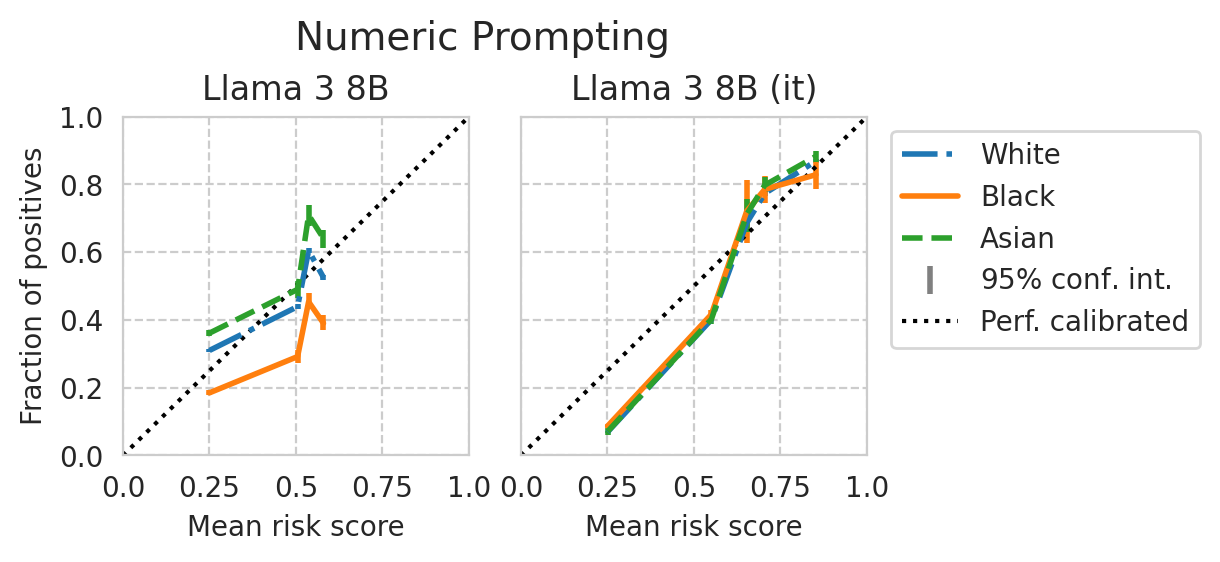

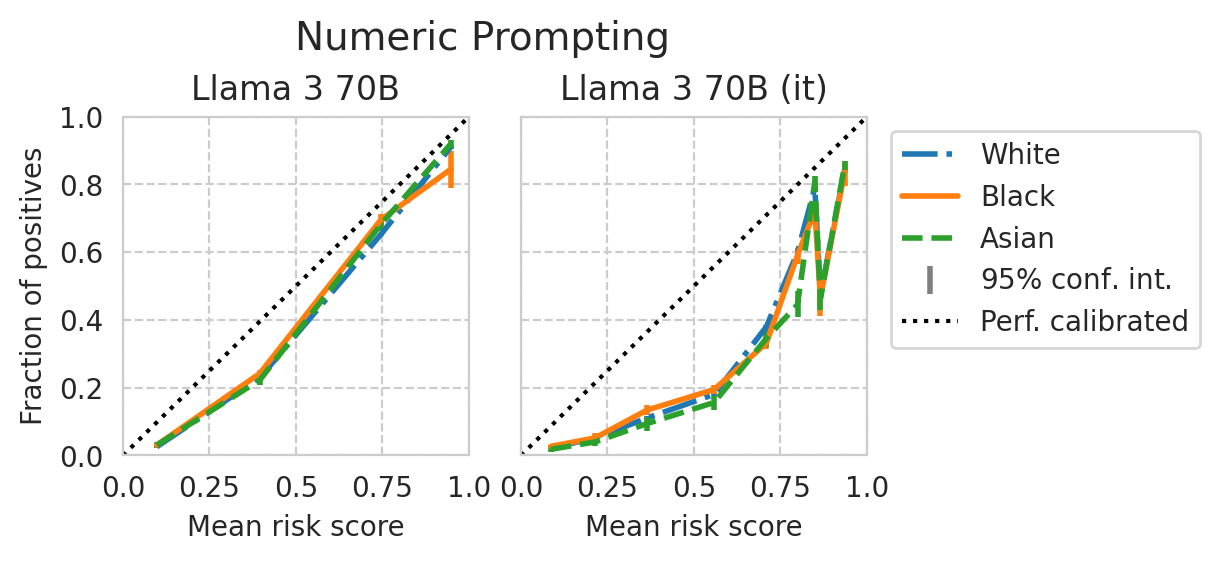

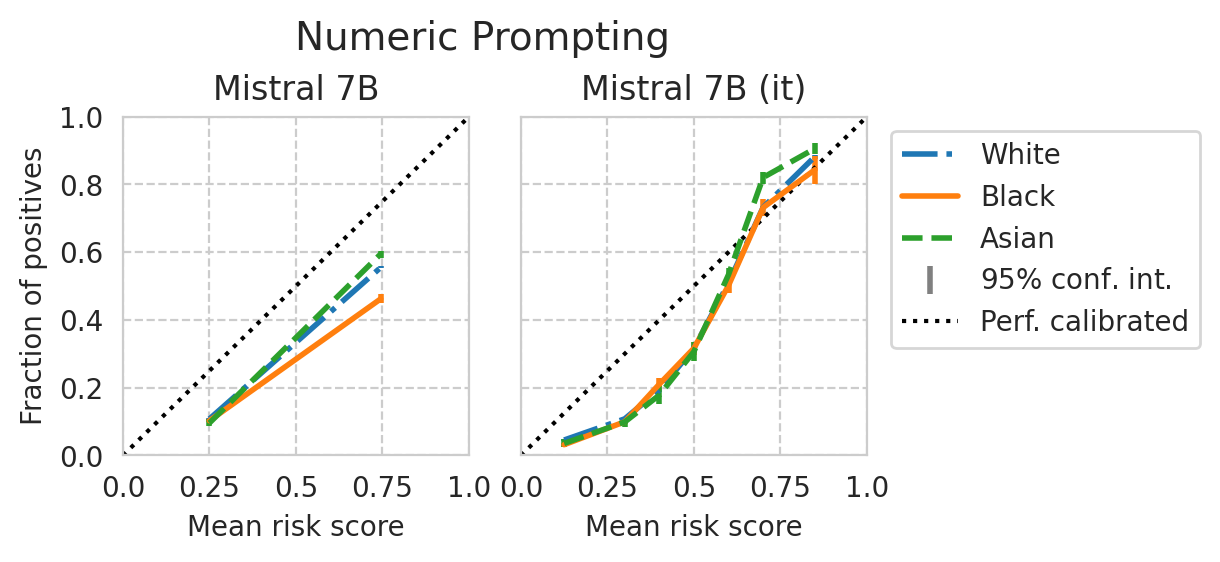

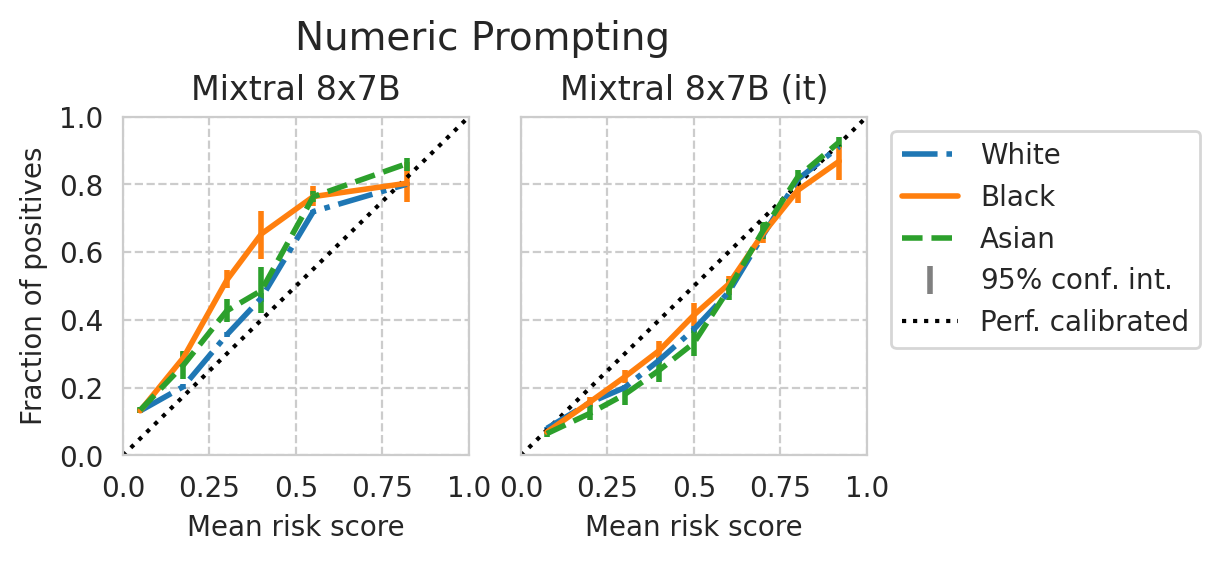

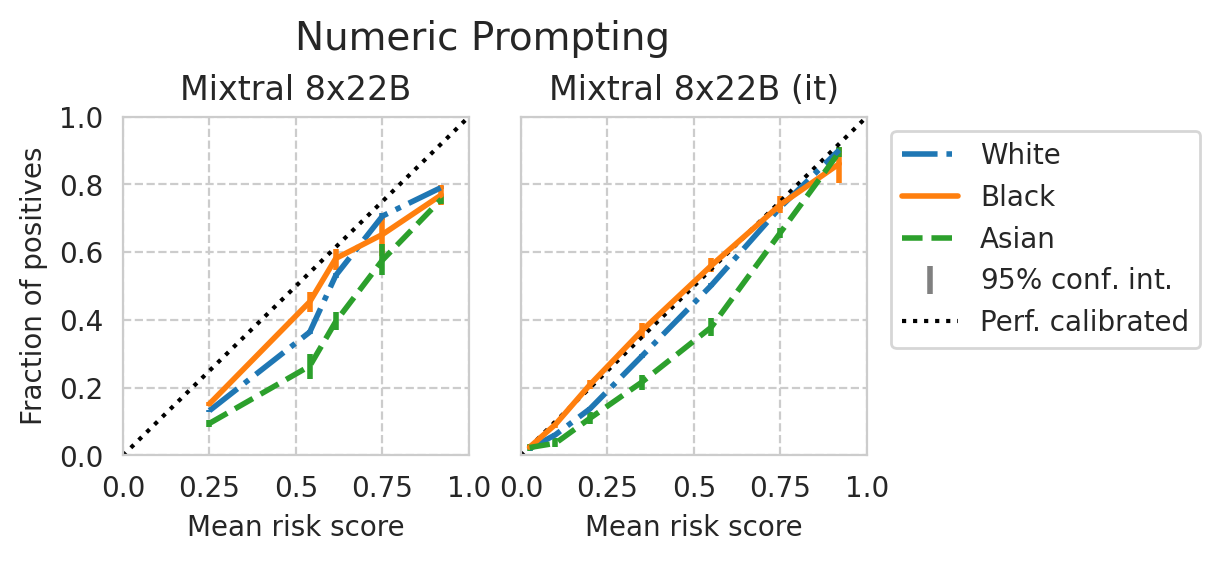

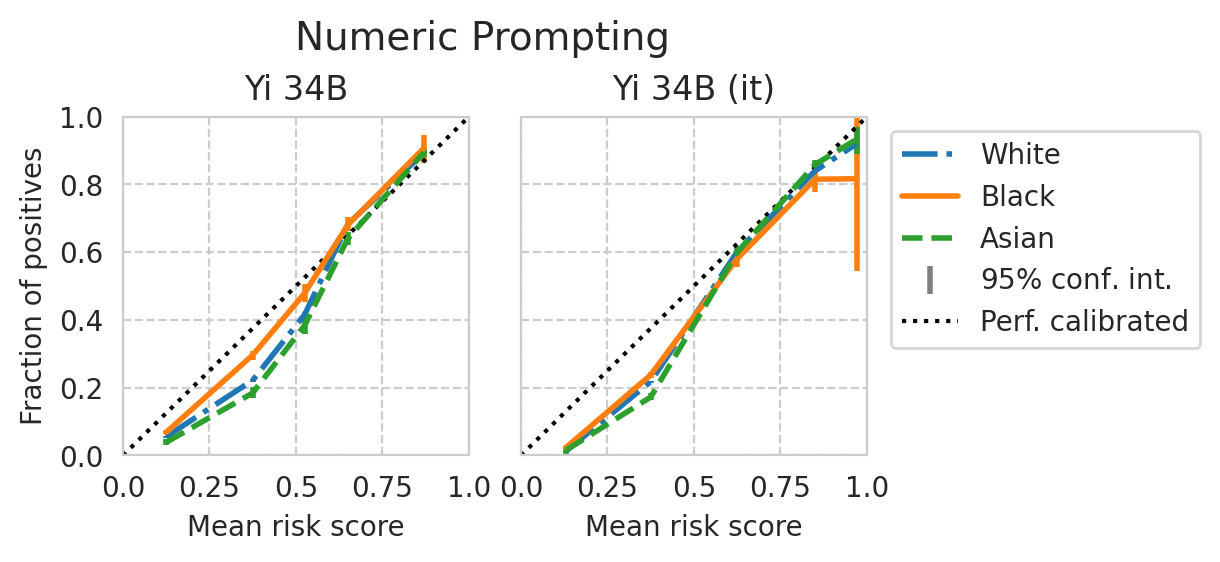

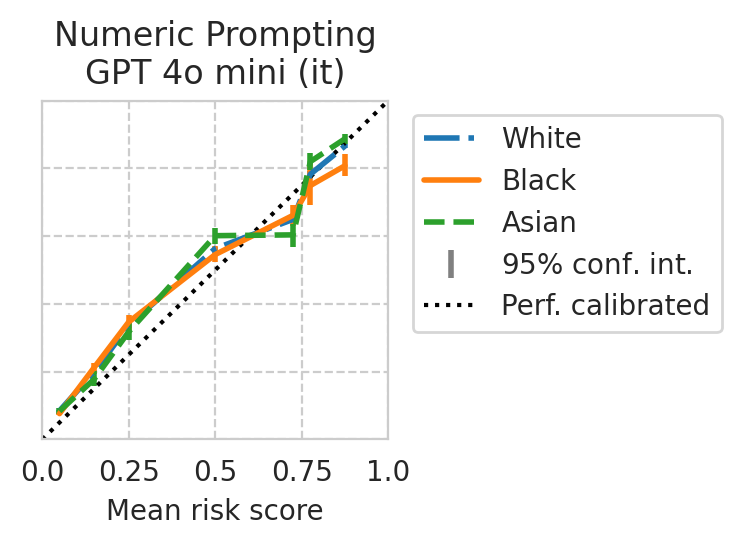

In [39]:
from sklearn.calibration import CalibrationDisplay

# Get results for the current task
task_df = all_results_df[all_results_df[task_col] == TASK]

# Get all base/instruct model pairs
base_models_to_plot = [
    "Meta-Llama-3-8B",
    "Meta-Llama-3-70B",
    "Mistral-7B-v0.1",
    "Mixtral-8x7B-v0.1",
    "Mixtral-8x22B-v0.1",
    "Yi-34B",
]
# NOTE: Gemma models have degenerate distributions that always predict the same score, can't plot calibration properly...

instr_models_to_plot = [
    df[
        (df["base_name"] == m)
        & (df[model_col] != m)
    ][model_col].iloc[0]
    for m in base_models_to_plot
]

# Add GPT models if any
instr_models_to_plot += [m[model_col] for _, m in df.iterrows() if "gpt" in m["name"].lower()]
base_models_to_plot += [None for _ in range(len(instr_models_to_plot) - len(base_models_to_plot))]

base_it_pairs = list(zip(base_models_to_plot, instr_models_to_plot))

for base_model, it_model in tqdm(base_it_pairs):
    fig, axes = plt.subplots(ncols=2, figsize=(4.8, 2.2), gridspec_kw=dict(wspace=0.15), sharey=True)

    for idx, ax, m in zip(range(len(axes)), axes, (base_model, it_model)):
        if m is None:
            ax.remove()
            continue

        curr_row = task_df[(task_df[model_col] == m) & (task_df["uses_all_features"])].iloc[0]
        curr_id = curr_row.name

        # # Original sklearn calibration plot:
        # plot_cali_curve(curr_id, ax=ax, df=task_df)

        # # Plot with confidence intervals:
        plot_cali_curve_ci(curr_id, ax=ax, df=task_df)
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        ax.set_xlabel("Mean risk score")
        if idx == 0:
            ax.set_ylabel("Fraction of positives")

        # Set prettier x-ticks
        xticks = (0, 0.25, 0.5, 0.75, 1)
        xticks_labels = ("0.0", "0.25", "0.5", "0.75", "1.0")
        ax.set_xticks(xticks, labels=xticks_labels)

    # Prepare legend
    axes[0].legend().remove()
    if NUMERIC_PROMPTING:
        axes[1].get_legend().set(loc="upper left", bbox_to_anchor=(1.03, 1))
    else:
        axes[1].legend().remove()

    # Figure title
    if NUMERIC_PROMPTING:
        title = "Numeric Prompting"
    else:
        title = "Multiple-choice Prompting"

    # Don't use suptitle for GPT4 (no base model)
    if base_model is not None:
        plt.suptitle(title, y=1.1, fontsize=14)
    else:
        model_title = axes[1].get_title()
        plt.title(f"{title}\n{model_title}")
    
    plt.plot()
    save_fig(fig, f"calibration-curves-per-subgroup.{base_model}.smaller.pdf")


## Score distribution per sub-group

In [40]:
sens_attr_data = acs_dataset.data[sens_attr_col]
sens_attr_data.head(3)

1    2
2    1
8    1
Name: RAC1P, dtype: int64

  0%|          | 0/7 [00:00<?, ?it/s]

Saved figure to '../results/imgs/score-per-subgroup.Meta-Llama-3-8B.numeric-prompt.pdf'
Saved figure to '../results/imgs/score-per-subgroup.Meta-Llama-3-70B.numeric-prompt.pdf'
Saved figure to '../results/imgs/score-per-subgroup.Mistral-7B-v0.1.numeric-prompt.pdf'
Saved figure to '../results/imgs/score-per-subgroup.Mixtral-8x7B-v0.1.numeric-prompt.pdf'
Saved figure to '../results/imgs/score-per-subgroup.Mixtral-8x22B-v0.1.numeric-prompt.pdf'
Saved figure to '../results/imgs/score-per-subgroup.Yi-34B.numeric-prompt.pdf'
Saved figure to '../results/imgs/score-per-subgroup.None.numeric-prompt.pdf'


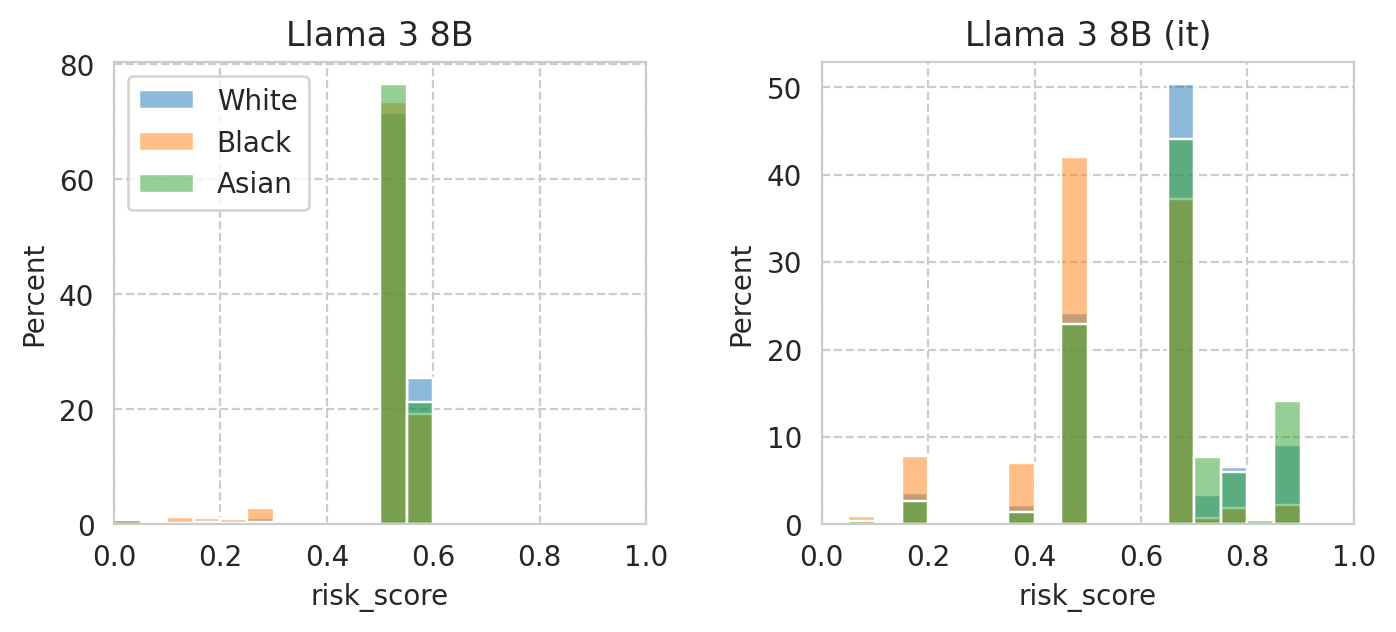

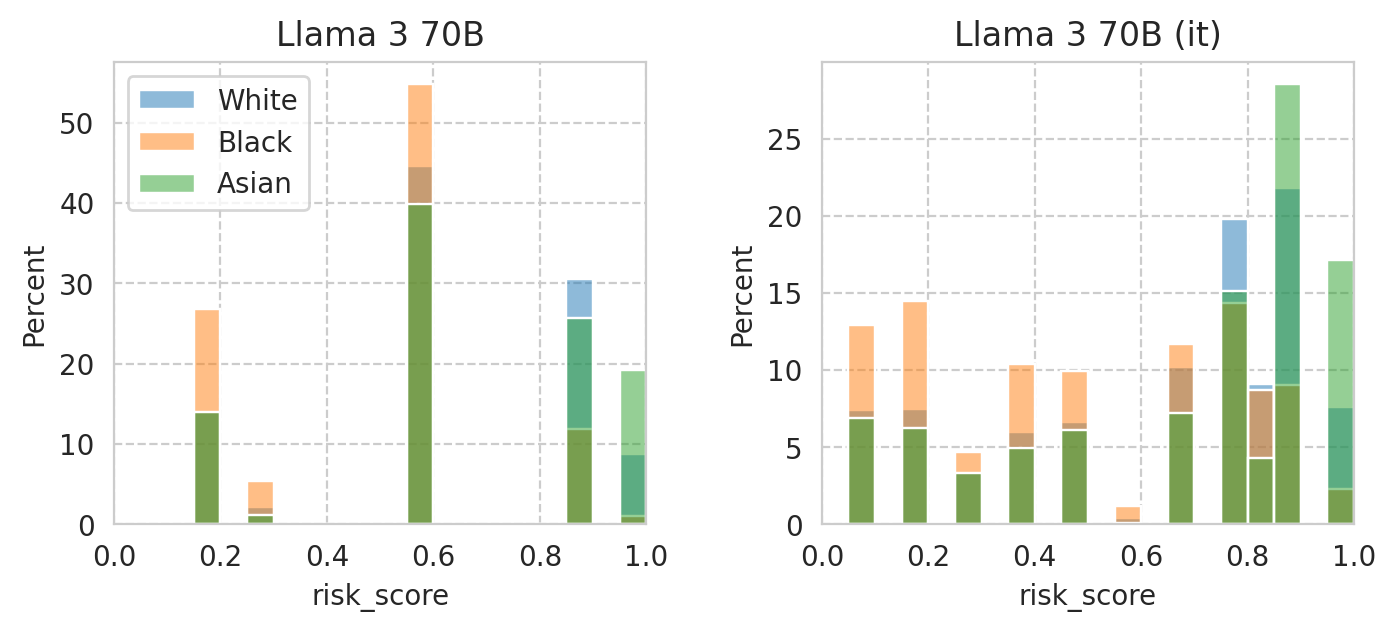

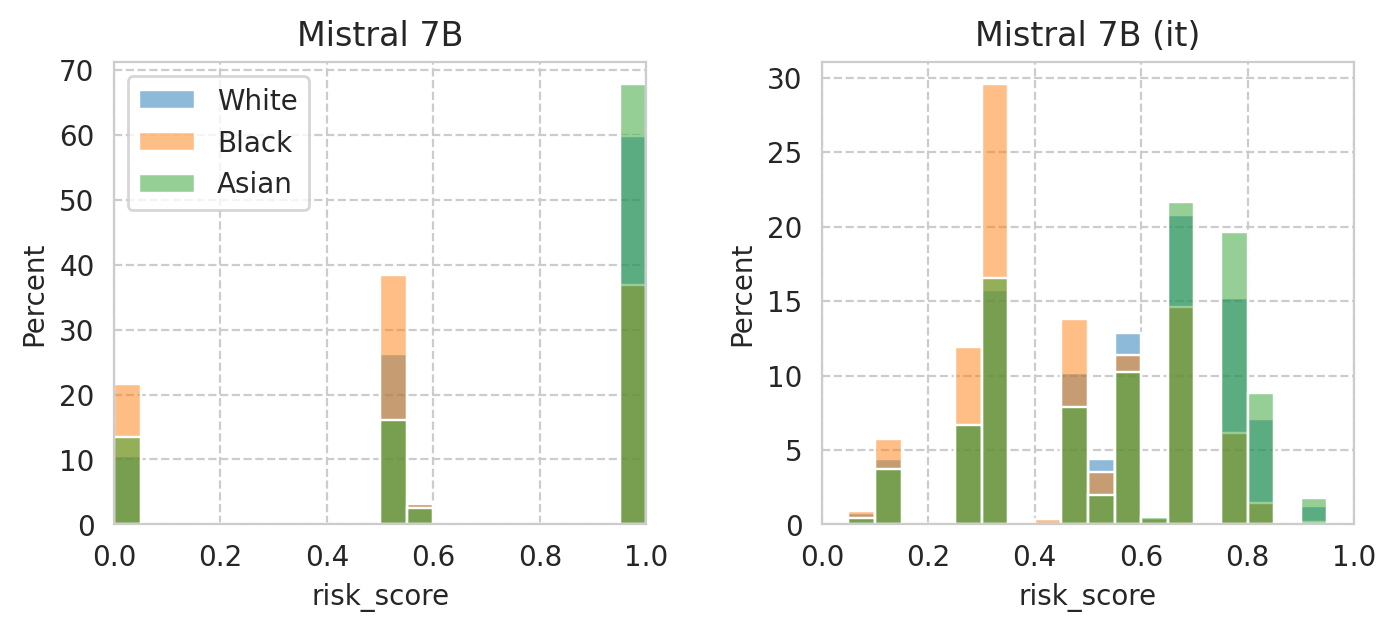

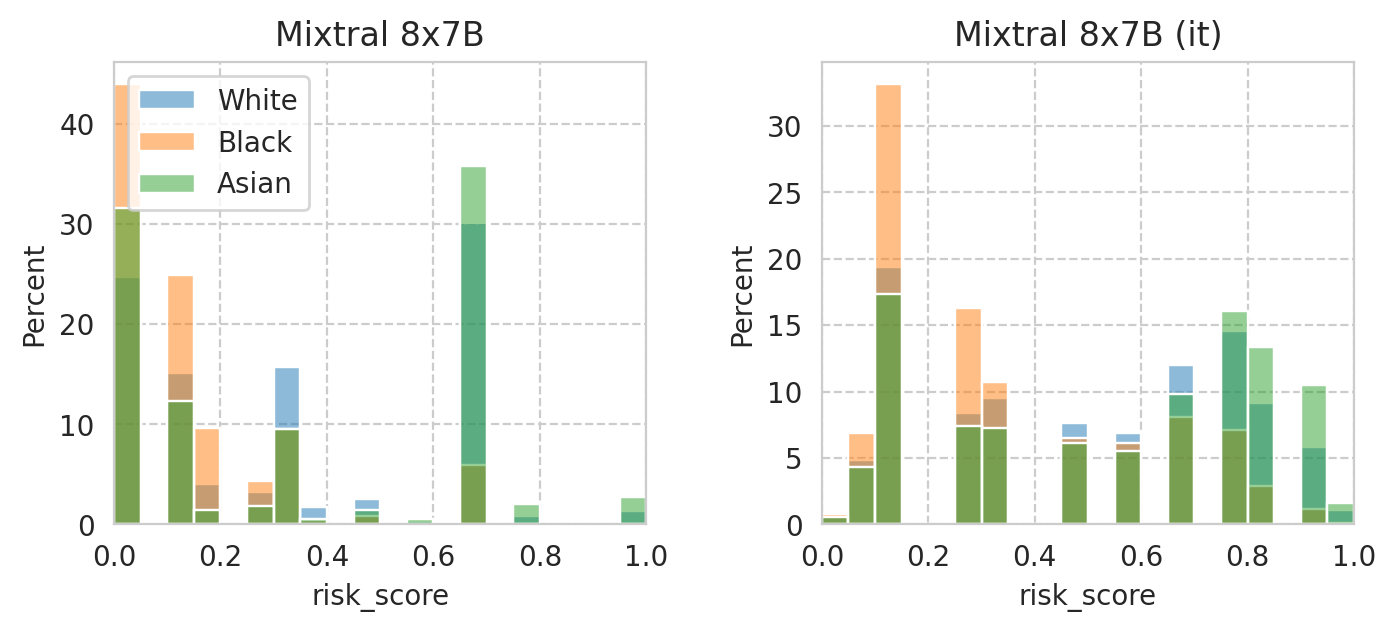

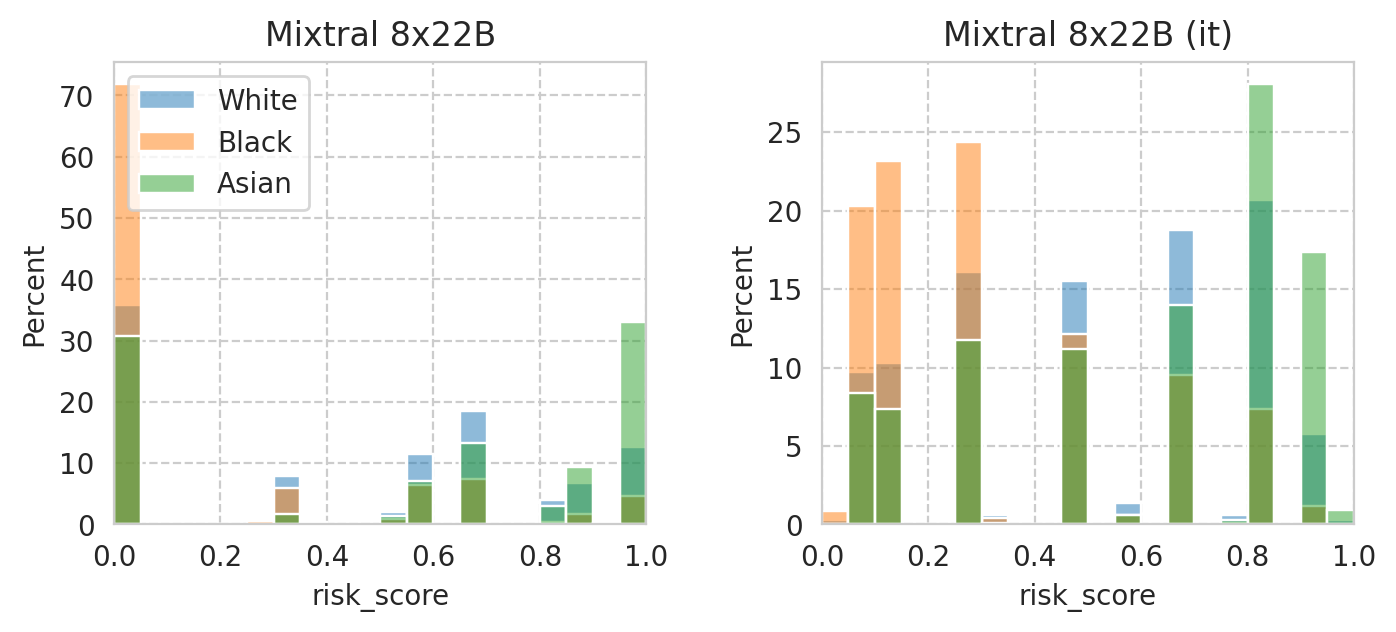

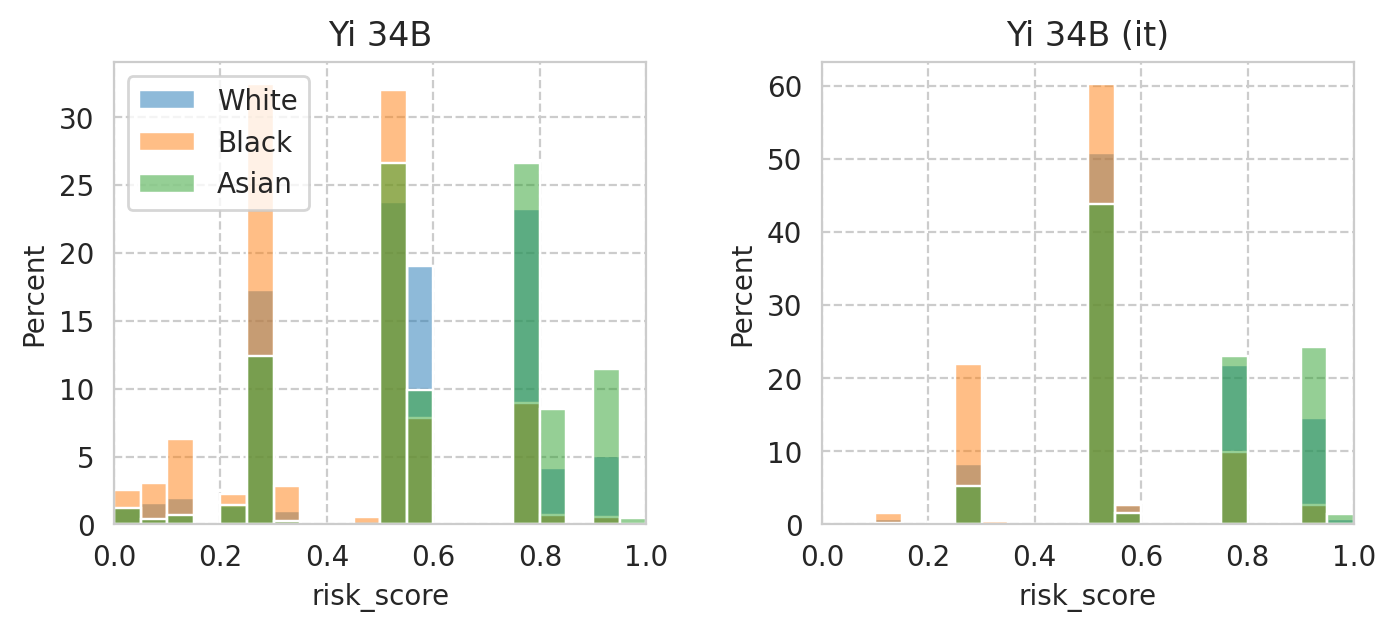

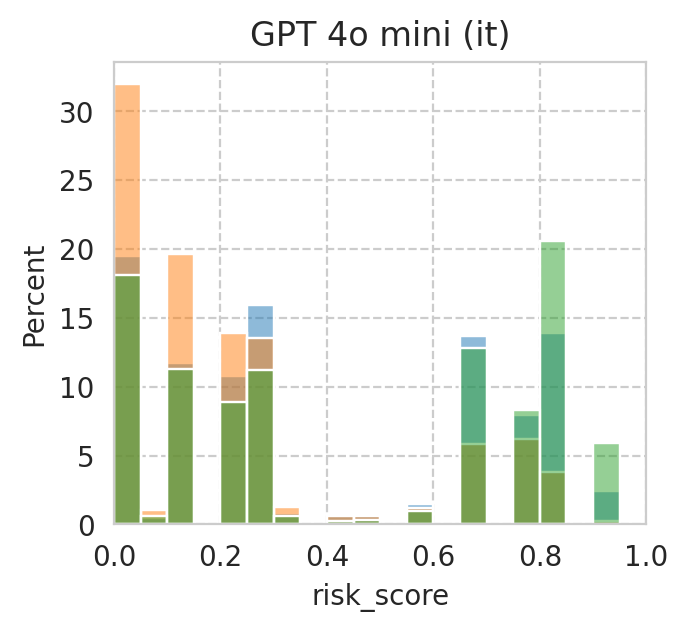

In [41]:
# Plot settings
plot_config = dict(
    bins=20,
    binrange=(0, 1),
    stat="percent",
)

for base_model, it_model in tqdm(base_it_pairs):
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3), gridspec_kw=dict(wspace=0.33), sharey=False)

    for idx, ax, m in zip(range(len(axes)), axes, (base_model, it_model)):
        if m is None:
            ax.remove()
            continue

        model_row = task_df[(task_df[model_col] == m) & (task_df["uses_all_features"])].iloc[0]
        model_id = model_row.name

        scores_df = scores_df_map[model_id]
        scores_df["group"] = sens_attr_data.loc[scores_df.index]

        # sns.histplot(
        #     data=scores_df,
        #     x="risk_score",
        #     hue="group",
        #     ax=ax,
        #     **plot_config,
        # )

        for group_val, group_name in sens_attr_map.items():
            group_scores_df = scores_df[sens_attr_data.loc[scores_df.index] == group_val]
            sns.histplot(
                group_scores_df["risk_score"],
                label=group_name,
                ax=ax,
                alpha=0.5,
                **plot_config,
            )

        # Remove left plot legend
        if idx == 0:
            ax.legend(loc="upper left")

        ax.set_xlim(0, 1)
        # ax.set_ylim(0, 1)

        ax.set_title(model_row["name"])

    plt.plot()
    save_fig(fig, f"score-per-subgroup.{base_model}.pdf")


## Compute mean under-/over-estimation of risk score
It's basocally akin to computing ECE without the absolute...

In [42]:
def compute_confidence_bias_metric_helper(data):
    """Helper to compute the under- / over-confidence metric.
    """
    mean_label = data["label"].mean()
    mean_score = data["risk_score"].mean()

    if mean_score < 0.5:
        return ((1 - mean_score) - (1 - mean_label))
    else:
        return (mean_score - mean_label)

def compute_confidence_bias_metric(model_id, quantiled_bins=False, scores_df=None):
    if scores_df is None:
        scores_df = scores_df_map[model_id]

    discretization_func = pd.qcut if quantiled_bins else pd.cut
    scores_df["score_bin"] = discretization_func(scores_df["risk_score"], 10, labels=range(10))
    
    bias_metric_val = (1 / len(scores_df)) * sum(
        len(bin_data) * compute_confidence_bias_metric_helper(bin_data)
        for bin_ in range(10)
        if len(bin_data := scores_df[scores_df["score_bin"] == bin_]) > 0
    )
    return float(bias_metric_val)

In [43]:
confidence_scores = {
    m: compute_confidence_bias_metric(m)
    for m in tqdm(scores_df_map.keys())
}

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
all_results_df["under_over_score"] = all_results_df.apply(lambda row: confidence_scores[row.name], axis=1)
all_results_df.sort_values("under_over_score", ascending=True)["under_over_score"]

Meta-Llama-3-8B-Instruct__ACSPublicCoverage__-1__Num     -0.161384
Mixtral-8x7B-Instruct-v0.1__ACSPublicCoverage__-1__Num   -0.061690
Mixtral-8x7B-Instruct-v0.1__ACSEmployment__-1__Num       -0.056597
Meta-Llama-3-70B-Instruct__ACSPublicCoverage__-1__Num    -0.052221
gemma-7b__ACSIncome__-1__Num                             -0.033482
                                                            ...   
gemma-7b__ACSEmployment__-1__Num                          0.341868
Mistral-7B-v0.1__ACSIncome__-1__Num                       0.355603
gemma-2b__ACSIncome__-1__Num                              0.367876
Mistral-7B-v0.1__ACSTravelTime__-1__Num                   0.438141
gemma-2b__ACSTravelTime__-1__Num                          0.438312
Name: under_over_score, Length: 100, dtype: float64

In [45]:
TASK = "ACSIncome"
# TASK = "ACSTravelTime"
# TASK = "ACSMobility"
# TASK = "ACSEmployment"

Saved figure to '../results/imgs/under_over_score.ACSIncome.numeric-prompt.pdf'


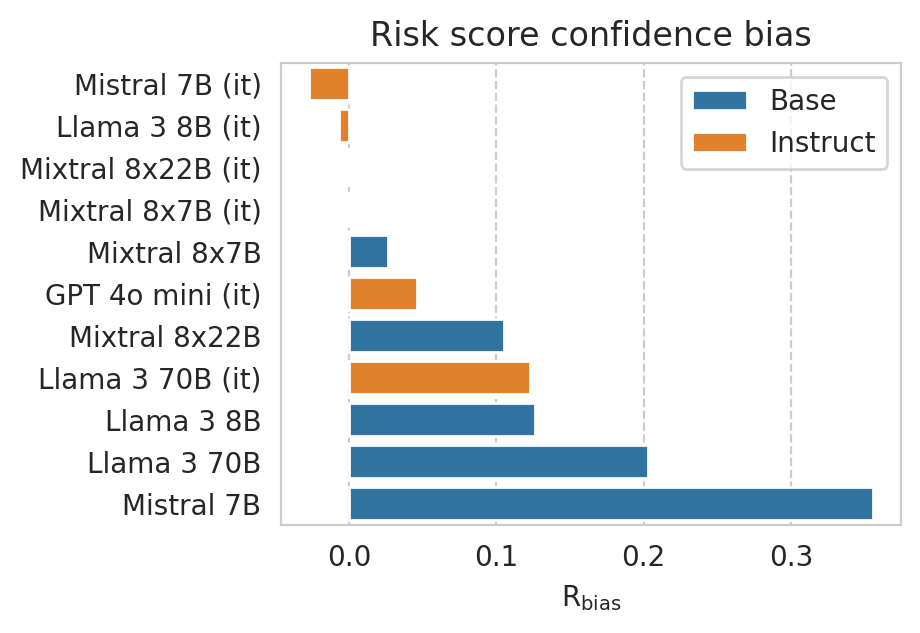

In [46]:
plot_df = all_results_df[
    (all_results_df[task_col] == TASK)
    & (~all_results_df[numeric_prompt_col].isna())
]

# Omit Gemma models bc they're garbage :)
plot_df = plot_df.drop(index=[id_ for id_ in plot_df.index if "gemma" in id_.lower() or "yi" in id_.lower()])


fig, ax = plt.subplots(figsize=(4, 3))
sns.barplot(
    data=plot_df.sort_values("under_over_score", ascending=True),
    x="under_over_score",
    y="name",
    # y=task_col,
    hue="is_inst",
    ax=ax,
)

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Base", "Instruct"])

plt.ylabel("")
plt.xlabel(r"$\mathrm{R}_\mathrm{bias}$")

plt.title(f"Risk score confidence bias")

save_fig(fig, f"under_over_score.{TASK}.pdf")

## Compute risk score fairness per sub-group

In [47]:
sens_attr_data = acs_dataset.data[sens_attr_col]
sens_attr_data.head(3)

1    2
2    1
8    1
Name: RAC1P, dtype: int64

In [48]:
def compute_signed_score_bias(scores_df, quantiled_bins=False, n_bins=10):
    discretization_func = pd.qcut if quantiled_bins else pd.cut
    scores_df["score_bin"] = discretization_func(scores_df["risk_score"], n_bins, duplicates="drop", retbins=False)
    bin_categories = scores_df["score_bin"].dtype.categories

    return (1 / len(scores_df)) * sum(
        len(bin_data) * (bin_data["risk_score"].mean() - bin_data["label"].mean())
        for bin_ in bin_categories
        if len(bin_data := scores_df[scores_df["score_bin"] == bin_]) > 0
    )

In [49]:
def compute_signed_subgroup_score_bias(model, group: int | str) -> float:
    scores_df = scores_df_map[model]
    if isinstance(group, str):
        group = name_to_sens_attr_map[group]

    scores_df = scores_df[sens_attr_data.loc[scores_df.index] == group]
    # return compute_confidence_metric(model, scores_df=scores_df)
    return compute_signed_score_bias(scores_df)


def compute_calibration_fairness(model: str, priv_group: int | str, unpriv_group: int | str) -> float:
    return (
        compute_signed_subgroup_score_bias(model, group=priv_group)
        - compute_signed_subgroup_score_bias(model, group=unpriv_group)
    )

In [50]:
calibration_per_subgroup_df = pd.DataFrame([
    pd.Series(
        {
            f"{group}_score_bias": compute_signed_subgroup_score_bias(model_id, group)
            for group in sens_attr_map.values()
        },
        name=model_id,
    )
    for model_id in task_df.index
])

calibration_per_subgroup_df["White_v_Black_score_bias"] = \
    calibration_per_subgroup_df["White_score_bias"] - calibration_per_subgroup_df["Black_score_bias"]

calibration_per_subgroup_df["White_v_Asian_score_bias"] = \
    calibration_per_subgroup_df["White_score_bias"] - calibration_per_subgroup_df["Asian_score_bias"]

calibration_per_subgroup_df["Asian_v_Black_score_bias"] = \
    calibration_per_subgroup_df["Asian_score_bias"] - calibration_per_subgroup_df["Black_score_bias"]

calibration_per_subgroup_df.sample(3)

/tmp/ipykernel_3388197/3464681156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df["score_bin"] = discretization_func(scores_df["risk_score"], n_bins, duplicates="drop", retbins=False)


,White_score_bias,Black_score_bias,Asian_score_bias,White_v_Black_score_bias,White_v_Asian_score_bias,Asian_v_Black_score_bias
Mistral-7B-v0.1__ACSIncome__-1__Num,0.353045,0.329428,0.319214,0.023617,0.033831,-0.010215
gemma-1.1-2b-it__ACSIncome__-1__Num,0.260100,0.403764,0.202488,-0.143664,0.057612,-0.201276
Yi-34B-Chat__ACSIncome__-1__Num,0.210531,0.229600,0.212839,-0.019069,-0.002308,-0.016761


**Note:** This is an example of comparing risk score bias between different sub-groups. A more detailed analysis must be conducted to draw any sort of conclusions regarding prediction fairness of the LLM.

Saved figure to '../results/imgs/score_bias.Asian_v_Black_score_bias.numeric-prompt.pdf'


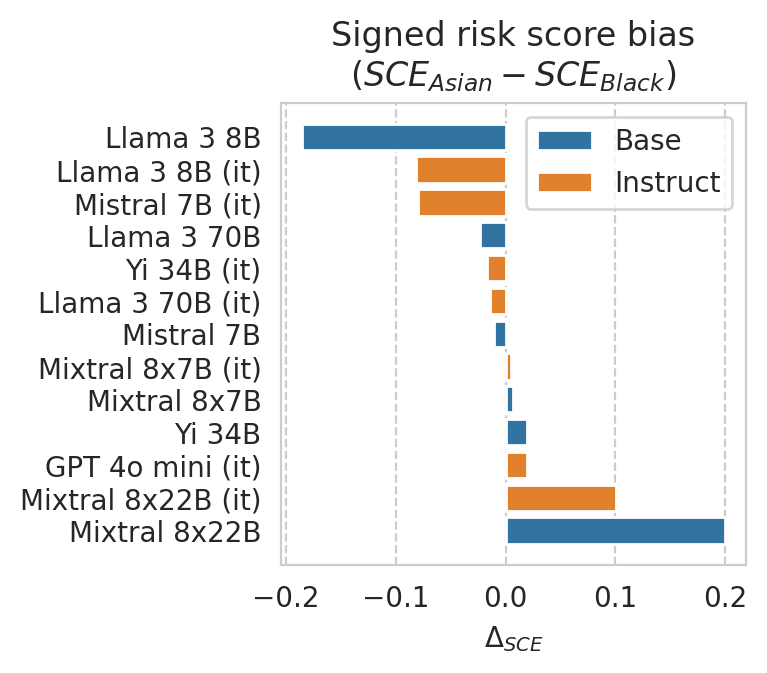

In [51]:
GROUP_A = "Asian"
# GROUP_A = "White"
GROUP_B = "Black"
# GROUP_B = "Asian"

COLUMN = f"{GROUP_A}_v_{GROUP_B}_score_bias"

plot_df = calibration_per_subgroup_df.join(results_df, how="left", validate="1:1")
plot_df = plot_df.drop(index=[id_ for id_ in plot_df.index if "gemma" in id_.lower()])   # omit Gemma models bc they're garbage :)

fig, ax = plt.subplots(figsize=(3, 3))
sns.barplot(
    data=plot_df.sort_values(COLUMN, ascending=True),
    x=COLUMN,
    y="name",
    hue="is_inst",
    ax=ax,
)

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Base", "Instruct"])

plt.ylabel("")
plt.xlabel("$\Delta_{SCE}$")

plt.title(
    "Signed risk score bias\n"
    + r"($SCE_{" + GROUP_A
    + r"} - SCE_{" + GROUP_B
    + r"}$)"
)

plt.plot()

save_fig(fig, f"score_bias.{COLUMN}.pdf")

In [52]:
plot_df.sort_values(COLUMN, ascending=False).head(3)

,White_score_bias,Black_score_bias,Asian_score_bias,White_v_Black_score_bias,White_v_Asian_score_bias,Asian_v_Black_score_bias,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,...,name,is_inst,num_features,uses_all_features,fit_thresh_on_100,fit_thresh_accuracy,optimal_thresh,optimal_thresh_accuracy,score_stdev,score_mean
Mixtral-8x22B-v0.1__ACSIncome__-1__Num,0.054322,-0.069436,0.130153,0.123758,-0.075831,0.199589,0.740583,0.148527,0.828562,0.761428,...,Mixtral 8x22B,False,-1.0,True,0.65,0.769300,0.45,0.740595,0.379947,0.411113
Mixtral-8x22B-Instruct-v0.1__ACSIncome__-1__Num,0.110399,0.055872,0.156710,0.054527,-0.046311,0.100837,0.767882,0.096716,0.885938,0.770218,...,Mixtral 8x22B (it),True,-1.0,True,0.65,0.769967,0.55,0.767882,0.298323,0.474955
penai/gpt-4o-mini__ACSIncome__-1__Num,-0.001300,-0.019960,-0.000407,0.018661,-0.000893,0.019553,0.777393,0.080767,0.904748,0.758922,...,GPT 4o mini (it),True,-1.0,True,0.65,0.777302,0.35,0.775512,0.317359,0.363743


---

# Plots comparing different prompting schemes

In [53]:
### Plot all models / i.t. / base?
IT_OR_BASE = "any"
# IT_OR_BASE = "it"
# IT_OR_BASE = "base"

### Plot which metric
METRIC = "ece"
# METRIC = "roc_auc"

In [54]:
# Prepare data
df = all_results_df_original.copy()

min_max_per_task = {
    task: (np.min(values), np.max(values))
    for task in ALL_TASKS
    if len(values := df[(df[task_col] == task) & (~df[numeric_prompt_col].isna())][METRIC]) > 0
}

# Sort models
sorted_df_index = sorted(
    df.index.tolist(),
    key=lambda id_: model_sort_key(id_, df),
    reverse=True,
)
df = df.loc[sorted_df_index]

if IT_OR_BASE == "it":
    print("Plotting IT models")
    df = df[df["is_inst"] == True]
elif IT_OR_BASE == "base":
    print("Plotting BASE models")
    df = df[df["is_inst"] == False]
else:
    print("Plotting ALL models")
    df = df.sort_values(by=["is_inst", "model_size"], ascending=False)

# Data for multiple-choice prompting
df_mult_choice = df[df[numeric_prompt_col] == False].set_index(["name", task_col], drop=False)

# Data for numeric risk prompting
df_numeric = df[df[numeric_prompt_col] == True].set_index(["name", task_col], drop=False)

# Sorted list of model names
model_names = df_numeric["name"].unique().tolist()[::-1]
n_models = len(model_names)
print(f"{model_names=}")

Plotting ALL models
model_names=['Gemma 2B', 'Gemma 7B', 'Mistral 7B', 'Llama 3 8B', 'Yi 34B', 'Mixtral 8x7B', 'Llama 3 70B', 'Mixtral 8x22B', 'Gemma 2B (it)', 'Gemma 7B (it)', 'Mistral 7B (it)', 'Llama 3 8B (it)', 'Yi 34B (it)', 'Mixtral 8x7B (it)', 'Llama 3 70B (it)', 'Mixtral 8x22B (it)', 'GPT 4o mini (it)']


Saved figure to '../results/imgs/ece_comparison_diff_prompts.any-models.pdf'


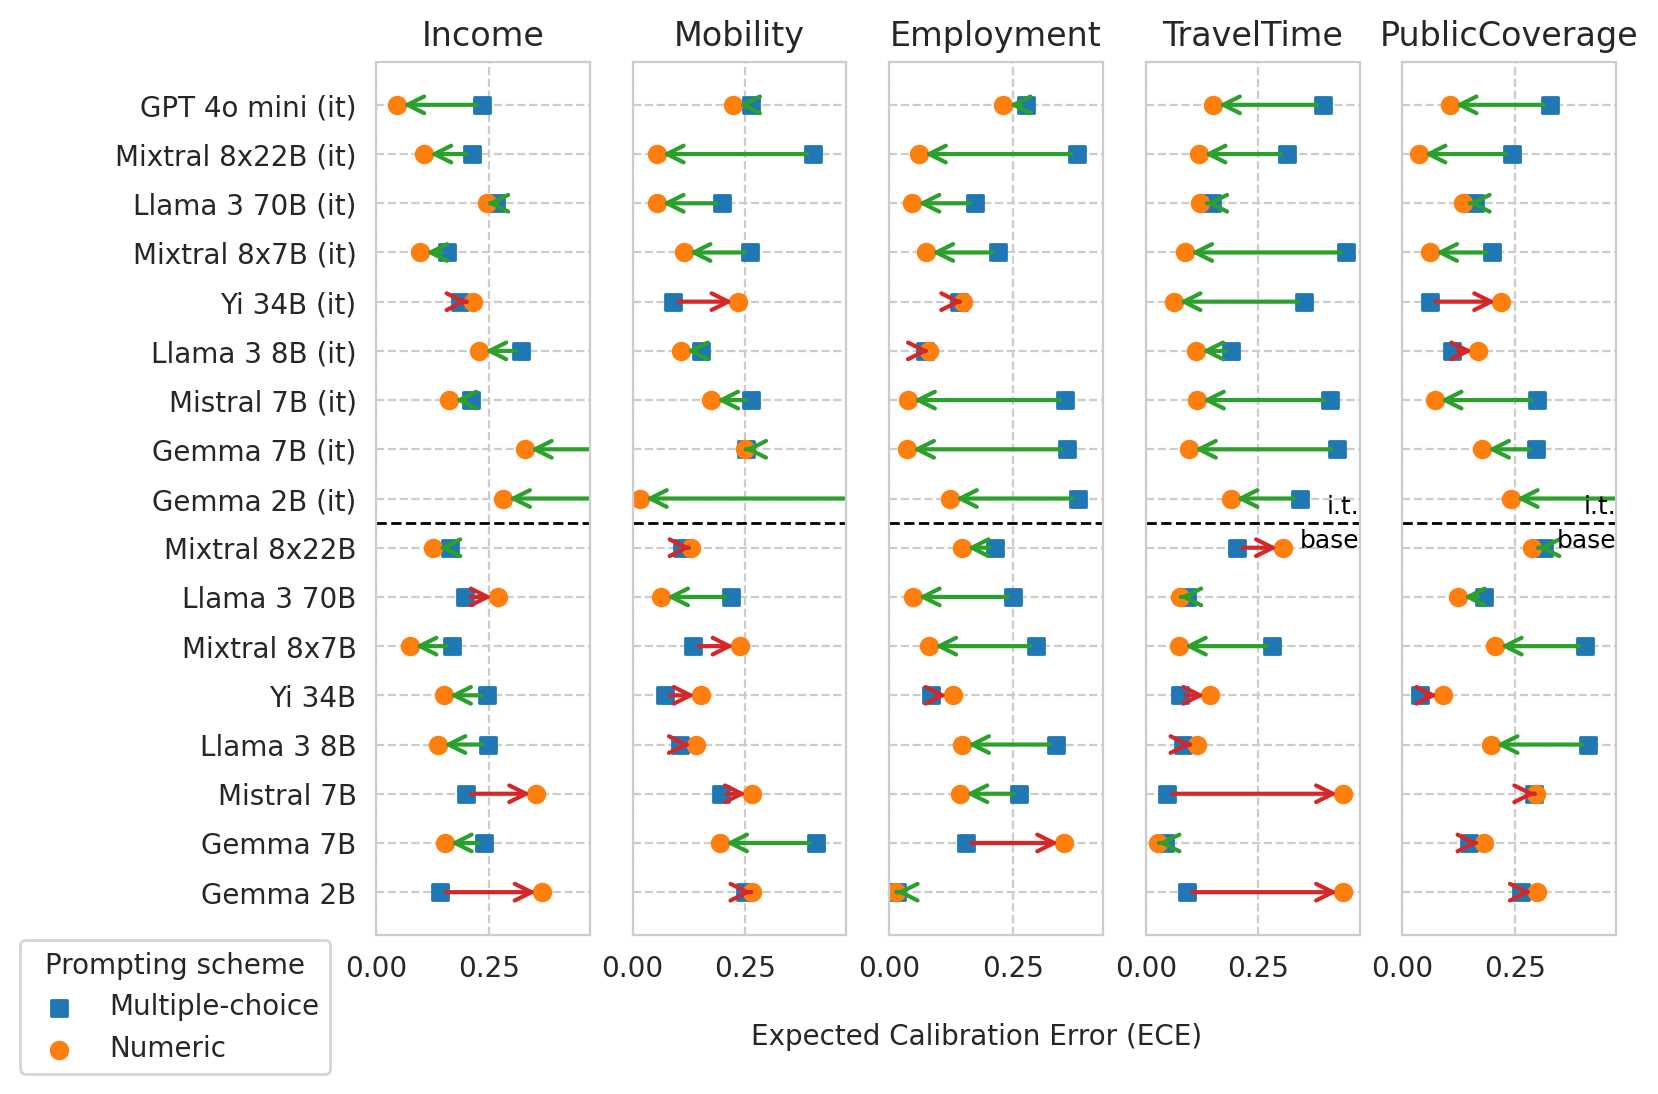

In [55]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Create a figure and axis
fig, axes = plt.subplots(ncols=len(ALL_TASKS), figsize=(8, n_models / 3), sharey=True)

for task_i, task in enumerate(ALL_TASKS):

    # Get current plot axis
    ax = axes[task_i]
        
    # Plot arrows for each model
    for i, model_name in enumerate(model_names):

        curr_mult_choice_metric = df_mult_choice.loc[model_name, task][METRIC]
        curr_numeric_metric = df_numeric.loc[model_name, task][METRIC]
        
        ax.scatter(
            curr_mult_choice_metric, i,
            color=palette[0], marker="s",
            label='Multiple-choice' if i == 0 else "",
        )
        ax.scatter(
            curr_numeric_metric, i,
            color=palette[1], marker="o",
            label='Numeric' if i == 0 else "",
        )

        # Draw a FancyArrowPatch arrow from before to after fine-tuning
        if METRIC == "ece":
            curr_metric_improved = curr_numeric_metric <= curr_mult_choice_metric
        else:
            curr_metric_improved = curr_numeric_metric >= curr_mult_choice_metric
        
        arrow = FancyArrowPatch(
            (curr_mult_choice_metric, i), (curr_numeric_metric, i),
            arrowstyle='->',
            color=palette[2] if curr_metric_improved else palette[3],
            mutation_scale=15,
            lw=1.5,
        )
        ax.add_patch(arrow)

        # Set axes ranges according to overall min/max values
        lo, hi = min_max_per_task[task]
        if METRIC == "ece":
            lo = max(lo - 5e-2, 0)
            hi = min(hi + 5e-2, 0.475)
        elif METRIC == "roc_auc":
            lo = max(lo - 5e-2, 0.475)
            hi = min(hi + 4e-2, 1)

        if task == "ACSIncome" and METRIC == "roc_auc":
            lo = 0.58
        ax.set_xlim(lo, hi)
    
    # Set y-ticks and y-labels
    ax.set_yticks(range(n_models))
    ax.set_yticklabels(model_names)

    # # Prettify x-axis ticks
    # xticks = ax.get_xticks()
    # ax.set_xticks(xticks, [f"{x}" for x in xticks])
    
    # Add labels and title
    # ax.set_xlabel('ECE')
    ax.set_title(task[3:])

    # Add horizontal line separating instruct and base models
    if IT_OR_BASE == "any":
        n_instruct_models = len(df_mult_choice[(df_mult_choice["is_inst"] == True) & (df_mult_choice[task_col] == task)])
        line_y = n_instruct_models - 1.5
        ax.axhline(line_y, color='black', linestyle='--', linewidth=1) #, label="instruct / base")

        # Add text label near the horizontal line
        if task_i > len(ALL_TASKS) - 3:
            text_kwargs = dict(
                horizontalalignment='right',
                transform=ax.get_yaxis_transform(),  # Use axis coordinates for y-axis
                fontsize=9, color='black',
            )

            ax.text(1, line_y + 0.1, 'i.t.', verticalalignment='bottom', **text_kwargs)
            ax.text(1, line_y - 0.1, 'base', verticalalignment='top', **text_kwargs)
        


# Add legend for marker
axes[0].legend(loc="upper right", bbox_to_anchor=(-0.15, 0.01), title="Prompting scheme")

# X-axis label
if METRIC == "ece":
    x_axis_label = "Expected Calibration Error (ECE)"
elif METRIC == "roc_auc":
    x_axis_label = "Predictive Power (ROC AUC)"

fig.text(0.5, 0.02 if IT_OR_BASE == "any" else -0.04, x_axis_label, horizontalalignment="center", verticalalignment="center")

# Save figure
save_fig(fig=fig, name=f"{METRIC}_comparison_diff_prompts.{IT_OR_BASE}-models.pdf", add_prompt_suffix=False)

# Show plot
plt.show()

## Scatter plot of ECE vs AUC for a few models (before and after numeric prompting)

Saved figure to '../results/imgs/comparison_diff_prompts.any-models.pdf'


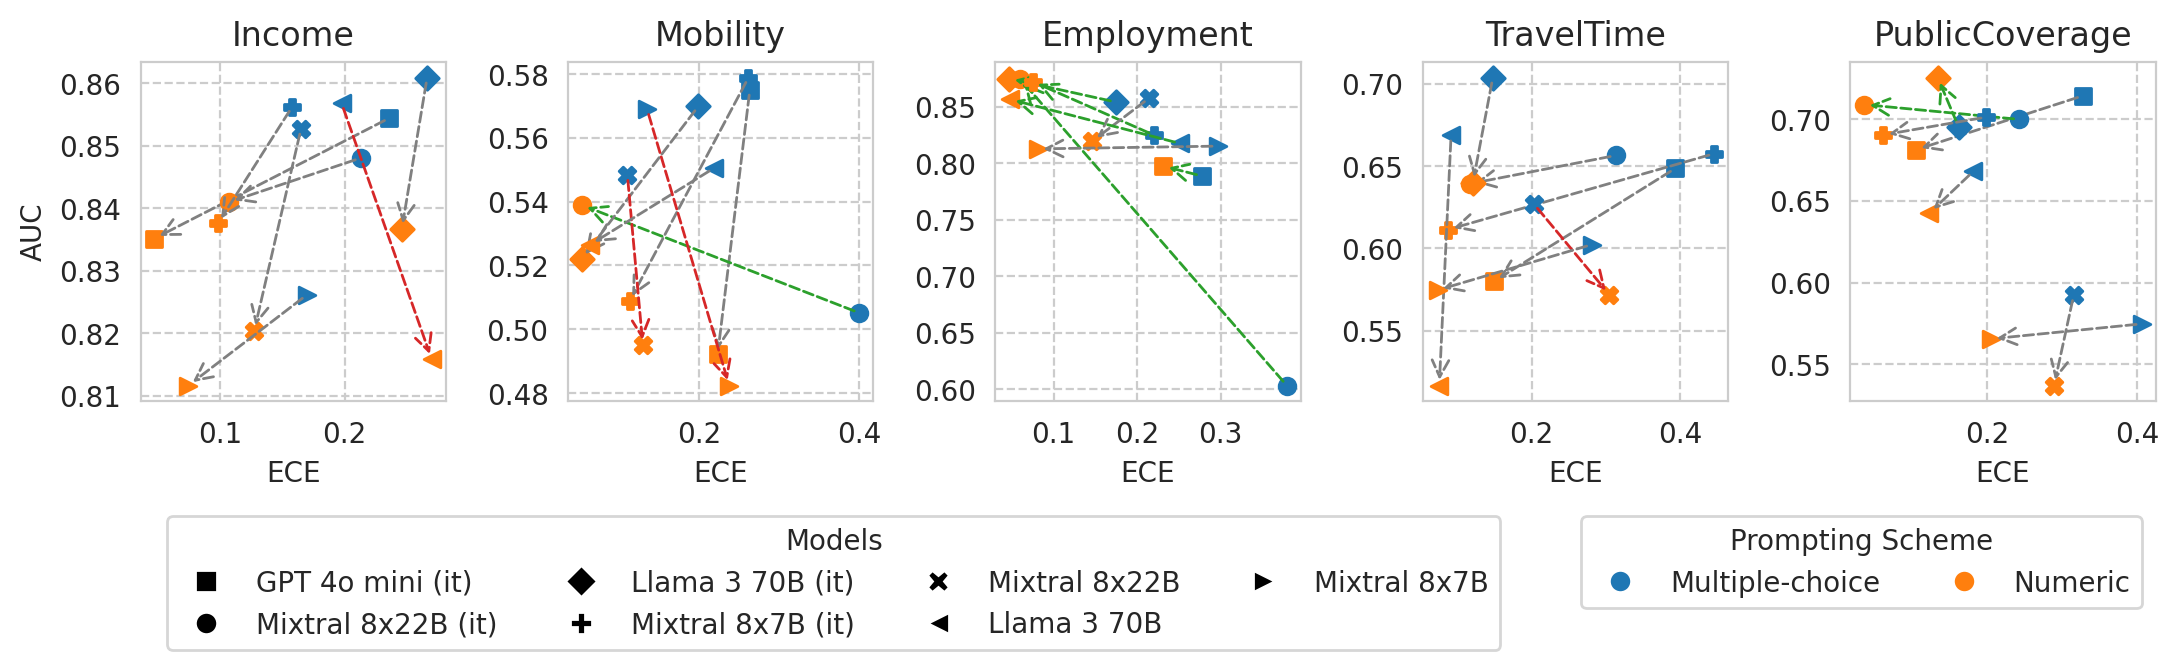

In [56]:
X_METRIC = "ece"
Y_METRIC = "roc_auc"

# Filter out small models
df_mult_choice = df_mult_choice[df_mult_choice["model_size"] > 50]
df_numeric = df_numeric[df_numeric["model_size"] > 50]

fig, axes = plt.subplots(ncols=len(ALL_TASKS), figsize=(len(ALL_TASKS) * 2.6, 2.2), gridspec_kw=dict(wspace=0.4))

unique_model_names = df_mult_choice.name.unique()
markers = dict(zip(unique_model_names, ["s", "o", "D", "P", "X", "<", ">"]))

for task_i, task in enumerate(ALL_TASKS):

    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(2.5, 2.5))

    ax = axes[task_i]
        
    # Plot arrows for each model
    for i, model_name in enumerate(df_mult_choice.name.unique()):

        # Get data for each plotting scheme
        curr_mult_choice_row = df_mult_choice.loc[model_name, task]
        curr_numeric_row = df_numeric.loc[model_name, task]

        # Get points to plot
        curr_mult_choice_point = (curr_mult_choice_row[X_METRIC], curr_mult_choice_row[Y_METRIC])
        curr_numeric_point = (curr_numeric_row[X_METRIC], curr_numeric_row[Y_METRIC])

        # Plot point for multiple-choice prompting
        ax.scatter(
            *curr_mult_choice_point,
            color=palette[0], marker=markers[model_name],
            label='Multiple-choice' if i == 0 else "",
        )

        # Plot point for numeric-style prompting
        ax.scatter(
            *curr_numeric_point,
            color=palette[1], marker=markers[model_name],
            label='Numeric' if i == 0 else "",
        )

        if curr_numeric_point[0] <=  curr_mult_choice_point[0] and curr_numeric_point[1] >=  curr_mult_choice_point[1]:
            arrow_color = palette[2]
        elif curr_numeric_point[0] >  curr_mult_choice_point[0] and curr_numeric_point[1] <  curr_mult_choice_point[1]:
            arrow_color = palette[3]
        else:
            arrow_color = "grey"

        # Draw a FancyArrowPatch arrow from before to after fine-tuning
        arrow = FancyArrowPatch(
            curr_mult_choice_point, curr_numeric_point,
            arrowstyle='->',
            color=arrow_color,
            mutation_scale=15,
            lw=1,
            ls="--",
        )
        ax.add_patch(arrow)

    ### Plot configs
    # Add labels and title
    ax.set_title(task[3:])
    ax.set_xlabel("ECE")
    if task_i == 0:
        ax.set_ylabel("AUC")

# Create custom global legend
from matplotlib.lines import Line2D

# Create a global legend for markers (model names)
marker_handles = [Line2D([0], [0], marker=markers[model], color='w', markerfacecolor='black', markersize=8, label=model) for model in unique_model_names]

# Create a global legend for colors (prompting schemes)
color_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[0], markersize=8, label="Multiple-choice"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[1], markersize=8, label="Numeric")
]

# Position the legends outside the subplots
fig.legend(handles=marker_handles, title="Models", loc='upper left', bbox_to_anchor=(0.13, -0.12), ncol=min(4, len(unique_model_names)))
fig.legend(handles=color_handles, title="Prompting Scheme", loc='upper right', bbox_to_anchor=(0.9, -0.12), ncol=2)

# Save figure
save_fig(fig=fig, name=f"comparison_diff_prompts.{IT_OR_BASE}-models.pdf", add_prompt_suffix=False)

plt.show()